Starting with data:      
At this stage we start by exploring the data, finding the mean and std of the numerical values, clean the data, renaming the columns, and remove the anomalities in order to start the ananlysis.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("Machinery_dataset_service.csv" )
print(df.head())       # View the first few rows

   Factor Year Factor Number Factor Date Customer ID         Order ID  \
0         2021    IA  000001  2021-01-06      cust01  2020/ON  003184   
1         2021    IT  000273  2021-01-31      cust02  2020/ON  007836   
2         2021    IT  000278  2021-01-31      cust03  2020/ON  001385   
3         2021    IT  000279  2021-01-31      cust04  2020/ON  008522   
4         2021    IT  000287  2021-01-31      cust05  2020/ON  008326   

       Start of rental        End of rental Machine ID              POLI Line  \
0  2020-06-03 00:00:00  2021-04-01 00:00:00    CLI1113  Silver Rent Allestiti   
1  2020-11-18 00:00:00  2021-03-09 00:00:00    CLI1097  Silver Rent Allestiti   
2  2020-02-20 00:00:00  2022-01-21 00:00:00    CLI0973    Silver Rent Furgoni   
3  2020-11-11 00:00:00  2021-06-18 00:00:00    CLI1098    Silver Rent Furgoni   
4  2020-11-30 00:00:00  2021-02-11 00:00:00       A181    Silver Rent Furgoni   

    Product Group Product Category  Amount Row Reason  Days Sold  \
0  Ren

In [2]:
# Step 1: getting to know the data
print(df.info())       # Get data types and null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43117 entries, 0 to 43116
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Factor Year       43117 non-null  int64  
 1   Factor Number     43117 non-null  object 
 2   Factor Date       43117 non-null  object 
 3   Customer ID       43117 non-null  object 
 4   Order ID          43117 non-null  object 
 5   Start of rental   43091 non-null  object 
 6   End of rental     43091 non-null  object 
 7   Machine ID        43117 non-null  object 
 8   POLI Line         43117 non-null  object 
 9   Product Group     43117 non-null  object 
 10  Product Category  40518 non-null  object 
 11  Amount            43117 non-null  float64
 12  Row Reason        43117 non-null  object 
 13  Days Sold         43117 non-null  float64
 14  Warehouse Unit    43117 non-null  object 
 15  Sales Quantity    43117 non-null  float64
 16  Sales Unit        43117 non-null  object

In [3]:
print(df.describe())   # Summary statistics for numerical columns

        Factor Year        Amount     Days Sold  Sales Quantity         Month
count  43117.000000  43117.000000  43117.000000    43117.000000  43097.000000
mean    2022.622794    706.860098      9.373785        6.487059      6.507042
std        1.152661    859.054978      9.850304        8.763374      3.418826
min     2021.000000   -180.000000     -3.000000        0.000000      1.000000
25%     2022.000000    130.000000      1.000000        1.000000      4.000000
50%     2023.000000    400.000000      5.000000        3.000000      6.000000
75%     2024.000000   1000.000000     20.000000        9.500000     10.000000
max     2024.000000  25200.000000    309.000000      828.000000     12.000000


In [4]:
### Step 2: handling null values, duplicates and anomalities
#  recognize Null values 
df.replace(["N\D", "#N/A", "NA", "nd", "-"], pd.NA, inplace=True)  # Convert specified values to null (NaN)

# Drop duplicated rows
df = df.drop_duplicates()

# Drop null values in specific columns (use the original column names at this step)
df = df.dropna(subset=[
	'Factor Year', 'Factor Number', 'Customer ID', 'Order ID', 'Start of rental', 'End of rental',
])

In [5]:
# Convert "Amount" to numeric where possible.
# Non-numeric entries will become NaN.
df["Amount_numeric"] = pd.to_numeric(df["Amount"], errors="coerce")

# Create a filter:
#  - Keep rows where the numeric conversion is NaN (i.e. the original "Importo" could not be converted, likely "-")
#  - Or, where the numeric value is non-negative.
df = df[(df["Amount_numeric"].isna()) | (df["Amount_numeric"] >= 0)].copy()

# Optionally, drop the temporary numeric column if no longer needed.
df.drop(columns=["Amount_numeric"], inplace=True)

# Display the resulting DataFrame.
print(df.head())

   Factor Year Factor Number Factor Date Customer ID         Order ID  \
0         2021    IA  000001  2021-01-06      cust01  2020/ON  003184   
1         2021    IT  000273  2021-01-31      cust02  2020/ON  007836   
2         2021    IT  000278  2021-01-31      cust03  2020/ON  001385   
3         2021    IT  000279  2021-01-31      cust04  2020/ON  008522   
4         2021    IT  000287  2021-01-31      cust05  2020/ON  008326   

       Start of rental        End of rental Machine ID              POLI Line  \
0  2020-06-03 00:00:00  2021-04-01 00:00:00    CLI1113  Silver Rent Allestiti   
1  2020-11-18 00:00:00  2021-03-09 00:00:00    CLI1097  Silver Rent Allestiti   
2  2020-02-20 00:00:00  2022-01-21 00:00:00    CLI0973    Silver Rent Furgoni   
3  2020-11-11 00:00:00  2021-06-18 00:00:00    CLI1098    Silver Rent Furgoni   
4  2020-11-30 00:00:00  2021-02-11 00:00:00       A181    Silver Rent Furgoni   

    Product Group Product Category  Amount Row Reason  Days Sold  \
0  Ren

In [6]:
## Recognizing Anomalities
# changing the format to datetime 
df["Start of rental"] = pd.to_datetime(df["Start of rental"], errors="coerce")
df["End of rental"] = pd.to_datetime(df["End of rental"], errors="coerce")

# filtering anomalities of time
df_unusual_contracts = df[
    (df["Start of rental"] <= pd.Timestamp("2010-01-01")) | 
    (df["End of rental"] >= pd.Timestamp("2040-12-31"))
].copy()

# Keeping the useful timeframe
df = df[
    (df["Start of rental"] > pd.Timestamp("2010-01-01")) & 
    (df["End of rental"] < pd.Timestamp("2040-12-31"))
].copy()

# checkiing the number of rows
print(f"✅ usual contracts {df.shape[0]}")
print(f"❌ unusual contract: {df_unusual_contracts.shape[0]}")

✅ usual contracts 43045
❌ unusual contract: 25


In [7]:
# Recalculate most recent and oldest dates
print("\n📌 After Filtering:")
print(f"Oldest 'Start of rental': {df['Start of rental'].min()}")
print(f"Most Recent 'Start of rental': {df['Start of rental'].max()}")
print(f"Oldest 'End of rental': {df['End of rental'].min()}")
print(f"Most Recent 'End of rental': {df['End of rental'].max()}")


📌 After Filtering:
Oldest 'Start of rental': 2014-07-22 00:00:00
Most Recent 'Start of rental': 2025-01-08 00:00:00
Oldest 'End of rental': 2020-11-09 00:00:00
Most Recent 'End of rental': 2029-06-30 00:00:00


In [8]:
# Step 3: Saving the cleaned data
df.to_csv("cleaned_dataset_service.csv", index=False)  # Save the cleaned DataFrame to a CSV file
# Display the first few rows of the cleaned DataFrame   
print(df.head())  # View the first few rows of the cleaned DataFrame

   Factor Year Factor Number Factor Date Customer ID         Order ID  \
0         2021    IA  000001  2021-01-06      cust01  2020/ON  003184   
1         2021    IT  000273  2021-01-31      cust02  2020/ON  007836   
2         2021    IT  000278  2021-01-31      cust03  2020/ON  001385   
3         2021    IT  000279  2021-01-31      cust04  2020/ON  008522   
4         2021    IT  000287  2021-01-31      cust05  2020/ON  008326   

  Start of rental End of rental Machine ID              POLI Line  \
0      2020-06-03    2021-04-01    CLI1113  Silver Rent Allestiti   
1      2020-11-18    2021-03-09    CLI1097  Silver Rent Allestiti   
2      2020-02-20    2022-01-21    CLI0973    Silver Rent Furgoni   
3      2020-11-11    2021-06-18    CLI1098    Silver Rent Furgoni   
4      2020-11-30    2021-02-11       A181    Silver Rent Furgoni   

    Product Group Product Category  Amount Row Reason  Days Sold  \
0  Rent Outfitted   Rent Outfitted  1426.0        ADN       31.0   
1    Rent 

In [9]:
# Display all unique values in the 'Product Category' column
print(df['Product Category'].unique())

['Rent Outfitted' 'Rent Vans' nan 'Rent with Crane'
 'Articulated Electric Boom Lifts' 'Rotating Telehandlers'
 'Electric Cranes' 'Subrental Vehicles' 'Fixed Telehandlers'
 'Diesel Vertical Lifts' 'Diesel/Electric Vertical Lifts'
 'Articulated Diesel Boom Lifts' 'Truck Cranes' 'Electric Vertical Lifts'
 'Telescopic Diesel Boom Lifts' 'Hybrid Articulated Boom Lifts'
 'Truck Mounted Articulated Platforms' 'Column Lifts' 'Spider Boom Lifts'
 'Telescopic Electric Boom Lifts' 'Generator Equipment'
 'Truck Mounted Telescopic Platforms' 'Machines with Operator' 'Operators'
 'Telehandler Accessory' 'Truck Platform Accessory']


In [10]:
# Remove specified values from the 'Product Category' column in df
values_to_remove = ['accessorio_sollevatore', 'accessorio_autocarrata', 'veicoli_subnoleggio', 'Accessori Gru Elettriche', 'Accessori Sollevatori Telescopici', 'Accessori Vari', 'Piazzalista', "Trasportatore"]
df = df[~df['Product Category'].isin(values_to_remove)].copy()

In [11]:
# Display all unique values in the 'Product Category' column
print(df['Product Group'].unique())

['Rent Outfitted' 'Rent Special' 'Rent Vans' 'Rent with Crane'
 'Rotating Boom Lifts' 'Telehandlers' 'Electric Cranes'
 'Subrental Vehicles' 'Vertical Lifts' 'Truck Cranes'
 'Truck Mounted Platforms' 'Column Lifts' 'Various Equipment'
 'Machines with Operator' 'Operators' <NA> 'Yard Staff'
 'Telehandler Accessory' 'Truck Platform Accessory'
 'Electric Crane Accessory' 'Various Accessories' 'Transporter']


In [12]:
# Remove specified values from the 'Product Group' column in df
values_to_remove = ['Accessori Gru Elettriche', 'Accessori Sollevatori Telescopici', 'Accessori Sollevatori Telescopici', 'veicoli_subnoleggio','Accessori Vari', "Piazzalista", 'Trasportatore']
df = df[~df['Product Group'].isin(values_to_remove)].copy()
# drop null values in 'Product Group'
df = df.dropna(subset=['Product Group'])

In [13]:
# Create Usage Duration
df["Contract Duration (days)"] = (df["End of rental"] - df["Start of rental"]).dt.days

We label the contracts based on theis duration into Daily, Monthly, and Annual in case to get insights later. 

In [14]:
# Categorize each Order ID based on contract duration
def categorize_rental(duration_days):
    if duration_days < 30:
        return "Daily"
    elif duration_days < 365:
        return "Monthly"
    else:
        return "Annual"

# Calculate contract duration for each Order ID (if not already present)
# Here, we use the already computed "Contract Duration (days)" column
order_duration = df.groupby("Order ID")["Contract Duration (days)"].max().reset_index()

# Apply categorization
order_duration["Rental_Type"] = order_duration["Contract Duration (days)"].apply(categorize_rental)

# Merge back to main DataFrame
df = df.merge(order_duration[["Order ID", "Rental_Type"]], on="Order ID", how="left")

# Show a sample of the result
print(df[["Order ID", "Contract Duration (days)", "Rental_Type"]].head(10))

          Order ID  Contract Duration (days) Rental_Type
0  2020/ON  003184                       302     Monthly
1  2020/ON  007836                       111     Monthly
2  2020/ON  001385                       701      Annual
3  2020/ON  008522                       219     Monthly
4  2020/ON  008326                        73     Monthly
5  2020/ON  008031                       893      Annual
6  2020/ON  009323                        80     Monthly
7  2020/ON  000087                       386      Annual
8  2019/ON  010621                       986      Annual
9  2020/ON  000528                       402      Annual


In [15]:
# Remove annual rental orders from the dataset
df_no_annual = df[df["Rental_Type"] != "Annual"].copy()

# Quick check: show the distribution of Rental_Type in the new dataset
print(df_no_annual["Rental_Type"].value_counts())

Daily      22324
Monthly    13355
Name: Rental_Type, dtype: int64


Interpurchase time calculations

Analyzing the dataset we realized that the behavior of the customers among the products is different. as a result having a strategy towards each product and considering both customer perspective and product perspective is vital. as a result, a mixed approach was considered to create customer ID - product category pairs and see the behavior of each customer towards each product category. hence, all the calcualtion regarding; Regularity, RFM and customer insights were done using this approach.

THE BACKGROUND OF THE ANALYSIS

Interpurchase Time refers to the time gap between two consecutive orders made by a customer. To evaluate how consistent a customer's ordering behavior is over time, we calculate the coefficient of variation (CV) of these interpurchase intervals—defined as the standard deviation divided by the mean. A low CV indicates stable, predictable gaps (high regularity), while a high CV reflects inconsistency and irregular ordering.

In this analysis, we distinguish between two types of regularity:

- Time Regularity: Measures the consistency of the time intervals between purchases.
- Quantity Regularity: Measures the consistency in the number of units rented per contract over time.

Both types of regularity were calculated from the perspective of each customer–product group pair (e.g., all Autocarrate orders by Customer 02).
These regularity metrics provide a behavioral layer that complements RFM scores and enables deeper segmentation and targeting strategies.

🎯 Why this analysis matters:
Understanding Time vs. Quantity Regularity:
We wanted to explore how predictable customers are—not just in when they rent, but for how long. This distinction gives us two behavioral axes:

- Time Regularity: Do they reorder on a rhythm (weekly, monthly, etc.)?
- Quantity Regularity: Do they tend to rent for similar durations each time?

C:\Users\SadrSystem\AppData\Local\Temp\ipykernel_488\1345521217.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(product_categories))


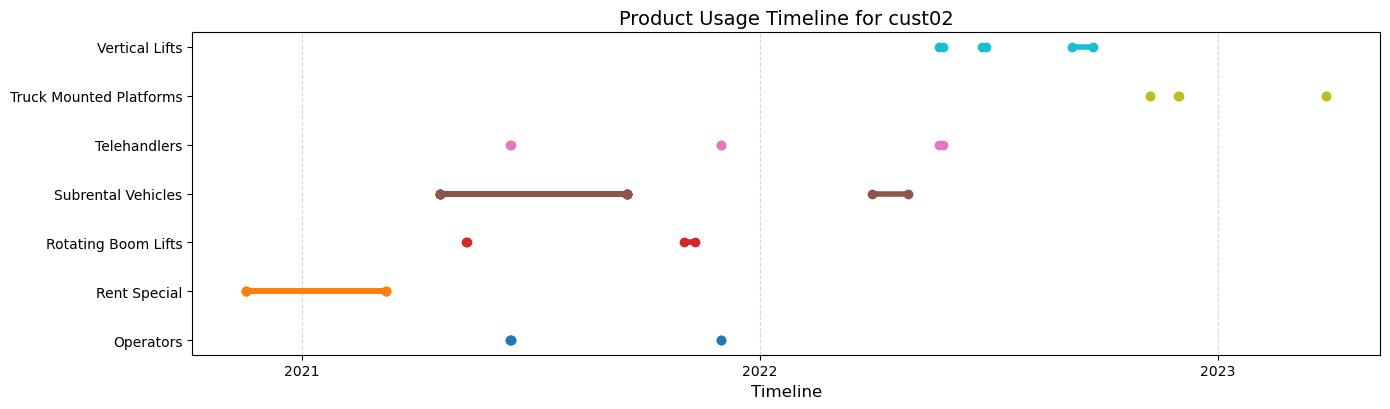

In [16]:
## Gantt-like Usage Timeline per Product for a Customer
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter for a single customer
customer_id = 'cust02'
df_customer = df[df['Customer ID'] == customer_id]

# Sort and group
product_categories = sorted(df_customer['Product Group'].unique())
color_map = plt.cm.get_cmap('tab10', len(product_categories))

fig, ax = plt.subplots(figsize=(14, len(product_categories) * 0.6))

for i, product in enumerate(product_categories):
    product_df = df_customer[df_customer['Product Group'] == product]
    color = color_map(i)

    for _, row in product_df.iterrows():
        start = row['Start of rental']
        end = row['End of rental']

        # Line for the duration
        ax.plot([start, end], [i, i], color=color, linewidth=4)

        # Circles at the ends
        ax.plot(start, i, 'o', color=color)
        ax.plot(end, i, 'o', color=color)

# Y-axis labels (products)
ax.set_yticks(range(len(product_categories)))
ax.set_yticklabels(product_categories, fontsize=10)

# Formatting
ax.set_xlabel("Timeline", fontsize=12)
ax.set_title(f'Product Usage Timeline for {customer_id}', fontsize=14)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [17]:
## Calculate Interpurchase Time for Each Customer–Product Group
# For customer-product level: Collapse the data so that each contract (Order ID) is unique per Customer and Product Group.
df_unique_contracts_custprod = (
    df
    .groupby(["Customer ID", "Product Group", "Order ID"], as_index=False)
    .agg({
        "Start of rental": "min",   # earliest start date of the contract
        "End of rental": "max",    # latest end date of the contract
    })
)

# Sort the data by Customer ID, Product Group, and "Start of rental".
df_unique_contracts_custprod = df_unique_contracts_custprod.sort_values(by=["Customer ID", "Product Group", "Start of rental"])

# For each Customer-Product group, shift the "End of rental" column to find the previous contract’s end date.
df_unique_contracts_custprod["Previous End of rental"] = (
    df_unique_contracts_custprod.groupby(["Customer ID", "Product Group"])["End of rental"].shift(1)
)

# Calculate the Interpurchase Time (in days) for each Customer-Product group.
df_unique_contracts_custprod["Interpurchase Time (cust.Prod)"] = (
    df_unique_contracts_custprod["Start of rental"] - df_unique_contracts_custprod["Previous End of rental"]
).dt.days

# Display a preview of the DataFrame.
print("Customer-Product Level Interpurchase Time:")
print(df_unique_contracts_custprod[
    ["Customer ID", "Product Group",  "Order ID", 
     "Start of rental","End of rental", "Previous End of rental", 
     "Interpurchase Time (cust.Prod)"]
].head(15))


Customer-Product Level Interpurchase Time:
   Customer ID            Product Group         Order ID Start of rental  \
0       cust01           Rent Outfitted  2020/ON  003184      2020-06-03   
1       cust01           Rent Outfitted  2021/ON  001016      2021-02-03   
2       cust02                Operators  2021/ON  005015      2021-06-16   
3       cust02                Operators  2021/ON  009759      2021-12-01   
4       cust02             Rent Special  2020/ON  007836      2020-11-18   
5       cust02      Rotating Boom Lifts  2021/ON  003140      2021-05-12   
6       cust02      Rotating Boom Lifts  2021/ON  008773      2021-11-02   
7       cust02       Subrental Vehicles  2021/ON  003210      2021-04-21   
8       cust02       Subrental Vehicles  2022/ON  002198      2022-03-31   
9       cust02             Telehandlers  2021/ON  005015      2021-06-16   
10      cust02             Telehandlers  2021/ON  009759      2021-12-01   
11      cust02             Telehandlers  2022

In [18]:
# Calculate the average interpurchase time for each Customer-Product pair.
avg_interpurchase_custProd = (
    df_unique_contracts_custprod
    .groupby(["Customer ID", "Product Group"])["Interpurchase Time (cust.Prod)"]
    .mean()
    .reset_index()
)

# Rename the aggregated column for clarity.
avg_interpurchase_custProd.rename(columns={"Interpurchase Time (cust.Prod)": "Avg_Interpurchase_Time_custProd"}, inplace=True)

Regularity Calculations - Time Based


In [19]:
# Calculate the average interpurchase time per Customer–Product pair including negatives.
avg_interpurchase_custProd = (
    df_unique_contracts_custprod
    .groupby(["Customer ID", "Product Group"])["Interpurchase Time (cust.Prod)"]
    .mean()
    .reset_index()
)
avg_interpurchase_custProd.rename(
    columns={"Interpurchase Time (cust.Prod)": "Avg_Interpurchase_Time_custProd"},
    inplace=True
)

# Print a preview:
print("Average Interpurchase Time (Customer-Product Level):")
print(avg_interpurchase_custProd.head())

# Now compute the Coefficient of Variation (CV) for interpurchase time.
# For each Customer–Product pair, we calculate the standard deviation and then
# compute the CV = std / |mean| so that the CV is positive.
time_regularity_custprod = (
    df_unique_contracts_custprod.groupby(["Customer ID", "Product Group"])["Interpurchase Time (cust.Prod)"]
    .agg(['mean','std'])
    .reset_index()
)
time_regularity_custprod.rename(
    columns={'mean': 'Mean_Interpurchase_Time_custprod', 'std': 'Std_Interpurchase_Time_custprod'},
    inplace=True
)

# Compute CV; use abs(mean) in the denominator.
time_regularity_custprod["CV_Interpurchase_Time_custprod"] = time_regularity_custprod.apply(
    lambda row: row["Std_Interpurchase_Time_custprod"] / abs(row["Mean_Interpurchase_Time_custprod"])
                if row["Mean_Interpurchase_Time_custprod"] and row["Mean_Interpurchase_Time_custprod"] != 0 else None,
    axis=1
)

print("Time-Based Regularity (Customer-Product Level) with CV:")
print(time_regularity_custprod.head())


Average Interpurchase Time (Customer-Product Level):
  Customer ID        Product Group  Avg_Interpurchase_Time_custProd
0      cust01       Rent Outfitted                            -57.0
1      cust02            Operators                            167.0
2      cust02         Rent Special                              NaN
3      cust02  Rotating Boom Lifts                            173.0
4      cust02   Subrental Vehicles                            195.0
Time-Based Regularity (Customer-Product Level) with CV:
  Customer ID        Product Group  Mean_Interpurchase_Time_custprod  \
0      cust01       Rent Outfitted                             -57.0   
1      cust02            Operators                             167.0   
2      cust02         Rent Special                               NaN   
3      cust02  Rotating Boom Lifts                             173.0   
4      cust02   Subrental Vehicles                             195.0   

   Std_Interpurchase_Time_custprod  CV_Interpurcha

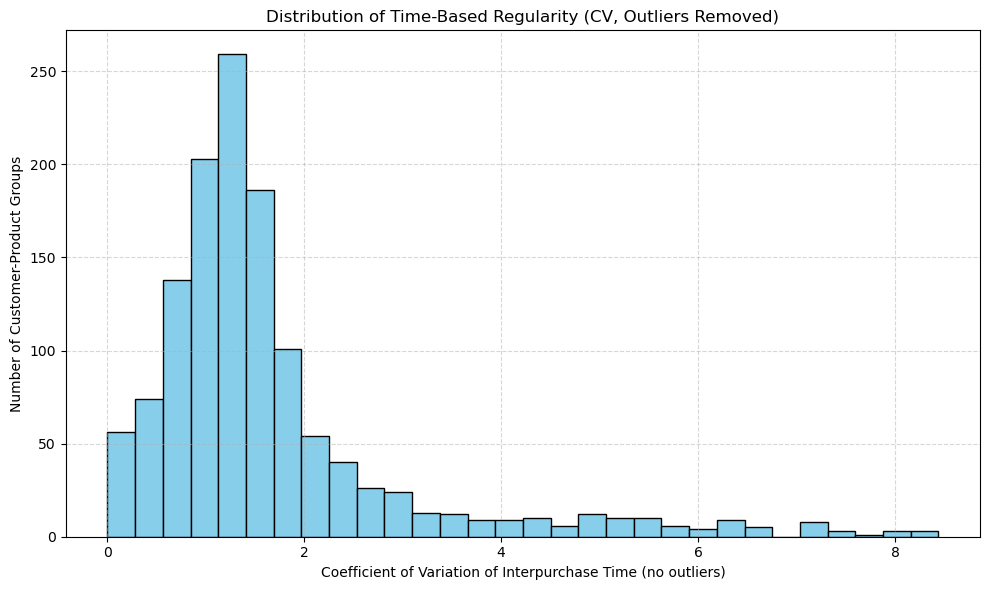

In [20]:
# Remove outliers: keep only CV values below the 95th percentile
cv_series = time_regularity_custprod["CV_Interpurchase_Time_custprod"].dropna()
cv_95 = cv_series.quantile(0.95)
cv_no_outliers = cv_series[cv_series <= cv_95]

plt.figure(figsize=(10, 6))
plt.hist(cv_no_outliers, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Coefficient of Variation of Interpurchase Time (no outliers)")
plt.ylabel("Number of Customer-Product Groups")
plt.title("Distribution of Time-Based Regularity (CV, Outliers Removed)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


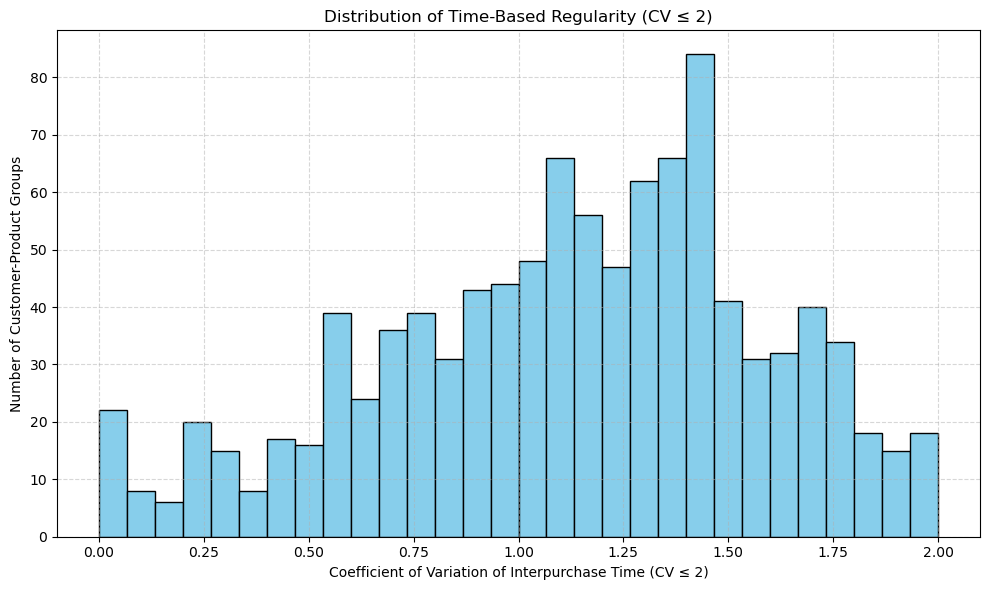

In [21]:
# Filter for CV values ≤ 2 (no outliers above 2)
cv_series = time_regularity_custprod["CV_Interpurchase_Time_custprod"].dropna()
cv_le_2 = cv_series[cv_series <= 2]

plt.figure(figsize=(10, 6))
plt.hist(cv_le_2, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Coefficient of Variation of Interpurchase Time (CV ≤ 2)")
plt.ylabel("Number of Customer-Product Groups")
plt.title("Distribution of Time-Based Regularity (CV ≤ 2)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In order to see clearly what is the distribution of quantity and time regularity, we removed the outliers by excluding the top 95 quantile. and we were able to see by this act, time regularity was up to CV = 8 while quantity regularity became up to CV = 2.  

In [22]:
# creating the time_regularity_custprod table
# 1) Count how many contracts each Customer–Product has
order_counts = (
    df_unique_contracts_custprod
    .groupby(["Customer ID","Product Group"])["Order ID"]
    .nunique()
    .reset_index(name="Num_Contracts")
)

# 2) Merge that count into your time_regularity table
time_regularity_custprod = time_regularity_custprod.merge(
    order_counts,
    on=["Customer ID","Product Group"],
    how="left"
)

# 3) Create two flags:
#    - single_purchase: exactly one contract ⇒ no real "gaps"
#    - multi_purchase: two or more contracts ⇒ at least one gap
# (Purchase_Type column removed as requested)

# 4) Further break out those with exactly 1 gap vs >1 gap:
# Use the correct column name for number of contracts
time_regularity_custprod["Gap_Count"] = time_regularity_custprod["Num_Contracts"] - 1
time_regularity_custprod["Gap_Type"] = pd.cut(
    time_regularity_custprod["Gap_Count"],
    bins=[-np.inf,0,1,np.inf],
    labels=["no_gap","one_gap","many_gaps"]
)

# --- Overlap calculations ---
# Flag overlaps where interpurchase time is negative
df_unique_contracts_custprod["Overlap_Flag"] = (
    df_unique_contracts_custprod["Interpurchase Time (cust.Prod)"] < 0
)

# Count overlaps per Customer–Product
overlap_counts = (
    df_unique_contracts_custprod
    .groupby(["Customer ID", "Product Group"])["Overlap_Flag"]
    .sum()
    .reset_index(name="Num_Overlaps")
)

# Create a descriptive label
overlap_counts["Contract_Overlap"] = overlap_counts["Num_Overlaps"].apply(
    lambda x: f"{int(x)} overlap{'s' if x != 1 else ''}"
)

# Merge overlap info into time_regularity_custprod
time_regularity_custprod = time_regularity_custprod.merge(
    overlap_counts,
    on=["Customer ID", "Product Group"],
    how="left"
)
time_regularity_custprod["Num_Overlaps"] = time_regularity_custprod["Num_Overlaps"].fillna(0).astype(int)
time_regularity_custprod["Contract_Overlap"] = time_regularity_custprod["Contract_Overlap"].fillna("0 overlaps")

# Show preview with overlaps
time_regularity_custprod.head(10)

,Customer ID,Product Group,Mean_Interpurchase_Time_custprod,Std_Interpurchase_Time_custprod,CV_Interpurchase_Time_custprod,Num_Contracts,Gap_Count,Gap_Type,Num_Overlaps,Contract_Overlap
0,cust01,Rent Outfitted,-57.000000,NaN,NaN,2,1,one_gap,1,1 overlap
1,cust02,Operators,167.000000,NaN,NaN,2,1,one_gap,0,0 overlaps
2,cust02,Rent Special,NaN,NaN,NaN,1,0,no_gap,0,0 overlaps
3,cust02,Rotating Boom Lifts,173.000000,NaN,NaN,2,1,one_gap,0,0 overlaps
4,cust02,Subrental Vehicles,195.000000,NaN,NaN,2,1,one_gap,0,0 overlaps
5,cust02,Telehandlers,170.500000,4.949747,0.029031,3,2,many_gaps,0,0 overlaps
6,cust02,Truck Mounted Platforms,69.500000,67.175144,0.966549,3,2,many_gaps,0,0 overlaps
7,cust02,Vertical Lifts,50.000000,26.870058,0.537401,3,2,many_gaps,0,0 overlaps
8,cust03,Rent Vans,-78.636364,366.683862,4.663032,12,11,many_gaps,2,2 overlaps
9,cust04,Rent Vans,NaN,NaN,NaN,1,0,no_gap,0,0 overlaps


LABELLING AND SCORING THE CV OF INTERPURCHASE TIME AND CV OF CONTRACT DURATION

In order to compare the values of Time Regularity and Quantity Regularity we give them scores and labels following the below logic.

In [23]:
# Assign time regularity Score based on CV_Interpurchase_Time_custprod
def time_regularity_Score(cv):
    if pd.isna(cv):
        return "No regularity"
    elif cv < 0.5:
        return "3"
    elif 0.5 <= cv < 1.5:
        return "2"
    else:
        return "1"

time_regularity_custprod["Time_Regularity_Score"] = time_regularity_custprod["CV_Interpurchase_Time_custprod"].apply(time_regularity_Score)


In [24]:
def time_regularity_label(cv):
    if pd.isna(cv):
        return "No regularity"
    elif cv < 0.5:
        return "H"
    elif 0.5 <= cv < 1.5:
        return "M"
    else:
        return "L"

time_regularity_custprod["Time_Regularity_Label_custprod"] = time_regularity_custprod["CV_Interpurchase_Time_custprod"].apply(time_regularity_label)

Regularity Calculations - Quantity Based

In [25]:
# Calculate Contract Duration (as previously computed).
df_unique_contracts_custprod["Contract_Duration"] = (
    df_unique_contracts_custprod["End of rental"] - df_unique_contracts_custprod["Start of rental"]
).dt.days

# Group by Customer-Product and calculate mean and std for duration.
quantity_regularity_custprod = (
    df_unique_contracts_custprod.groupby(["Customer ID", "Product Group"])["Contract_Duration"]
    .agg(['mean','std'])
    .reset_index()
)
quantity_regularity_custprod.rename(
    columns={'mean': 'Mean_Contract_Duration_custprod', 'std': 'Std_Contract_Duration_custprod'},
    inplace=True
)

# Compute CV for contract durations.
quantity_regularity_custprod["CV_Contract_Duration_custprod"] = quantity_regularity_custprod.apply(
    lambda row: row["Std_Contract_Duration_custprod"] / row["Mean_Contract_Duration_custprod"]
                if row["Mean_Contract_Duration_custprod"] and row["Mean_Contract_Duration_custprod"] != 0 else None,
    axis=1
)

# flaging the null values in Std_Contract_Duration_custprod
# 1) Count contracts per customer–product
qty_counts = (
    df_unique_contracts_custprod
      .groupby(["Customer ID","Product Group"])["Order ID"]
      .nunique()
      .reset_index(name="Num_Contracts")
)

# 2) Merge into quantity_regularity
quantity_regularity_custprod = quantity_regularity_custprod.merge(
    qty_counts, on=["Customer ID","Product Group"], how="left"
)

# 3) Flag the source of NaNs in Std_Contract_Duration_custprod
def flag_qty_nan(row):
    if pd.notna(row["Std_Contract_Duration_custprod"]):
        return "ok"
    if row["Num_Contracts"] == 1:
        return "single_contract"
    return "other"

quantity_regularity_custprod["Quantity_NaN_Reason"] = quantity_regularity_custprod.apply(flag_qty_nan, axis=1)

# 4) View only the rows where Std or CV is NaN, showing the reason
nan_cases = quantity_regularity_custprod[
    quantity_regularity_custprod["Std_Contract_Duration_custprod"].isna() |
    quantity_regularity_custprod["CV_Contract_Duration_custprod"].isna()
]


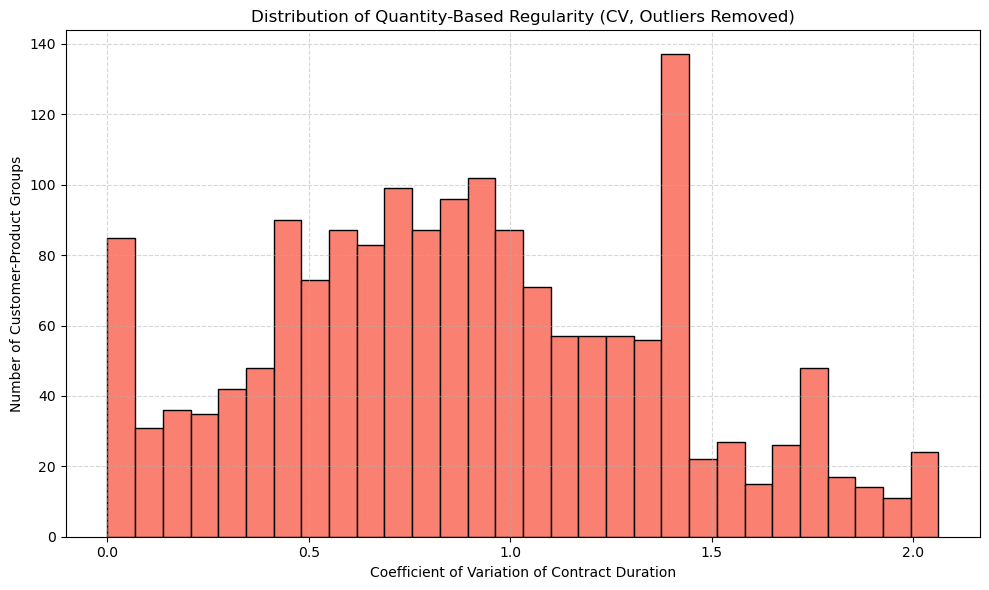

In [26]:
# Remove outliers above the 95th percentile for CV_Contract_Duration_custprod
cv_series = quantity_regularity_custprod["CV_Contract_Duration_custprod"].dropna()
cv_95 = cv_series.quantile(0.95)
cv_no_outliers = cv_series[cv_series <= cv_95]

# Plot a histogram of CV for quantity regularity (outliers removed)
plt.figure(figsize=(10,6))
plt.hist(cv_no_outliers, bins=30, color='salmon', edgecolor='black')
plt.xlabel("Coefficient of Variation of Contract Duration")
plt.ylabel("Number of Customer-Product Groups")
plt.title("Distribution of Quantity-Based Regularity (CV, Outliers Removed)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [27]:
print("Quantity-Based Regularity (Customer-Product Level):")
print(quantity_regularity_custprod.head(10))

Quantity-Based Regularity (Customer-Product Level):
  Customer ID            Product Group  Mean_Contract_Duration_custprod  \
0      cust01           Rent Outfitted                       152.000000   
1      cust02                Operators                         0.500000   
2      cust02             Rent Special                       111.000000   
3      cust02      Rotating Boom Lifts                         4.500000   
4      cust02       Subrental Vehicles                        89.000000   
5      cust02             Telehandlers                         1.333333   
6      cust02  Truck Mounted Platforms                         0.333333   
7      cust02           Vertical Lifts                         7.333333   
8      cust03                Rent Vans                       180.333333   
9      cust04                Rent Vans                       219.000000   

   Std_Contract_Duration_custprod  CV_Contract_Duration_custprod  \
0                      212.132034                     

In [28]:
# Assign quantity regularity Score based on CV_Contract_Duration_custprod
def quantity_regularity_Score(cv):
    if pd.isna(cv):
        return "No regularity"
    elif cv < 0.5:
        return "3"
    elif 0.5 <= cv < 1.5:
        return "2"
    else:
        return "1"

quantity_regularity_custprod["Quantity_Regularity_Score"] = quantity_regularity_custprod["CV_Contract_Duration_custprod"].apply(quantity_regularity_Score)


In [29]:
# Assign quantity regularity labels for customer-product pairs using the provided rule
def quantity_regularity_label(cv):
    if pd.isna(cv):
        return "No regularity"
    elif cv < 0.5:
        return "H"
    elif 0.5 <= cv < 1.5:
        return "M"
    else:
        return "L"

quantity_regularity_custprod["Quantity_Regularity_Label_custprod"] = quantity_regularity_custprod["CV_Contract_Duration_custprod"].apply(quantity_regularity_label)

C:\Users\SadrSystem\AppData\Local\Temp\ipykernel_488\1747935806.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_dist_with_null = cv_dist.append(pd.Series({"NaN": null_count}))
C:\Users\SadrSystem\AppData\Local\Temp\ipykernel_488\1747935806.py:20: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qty_cv_dist_with_null = qty_cv_dist.append(pd.Series({"NaN": qty_null_count}))


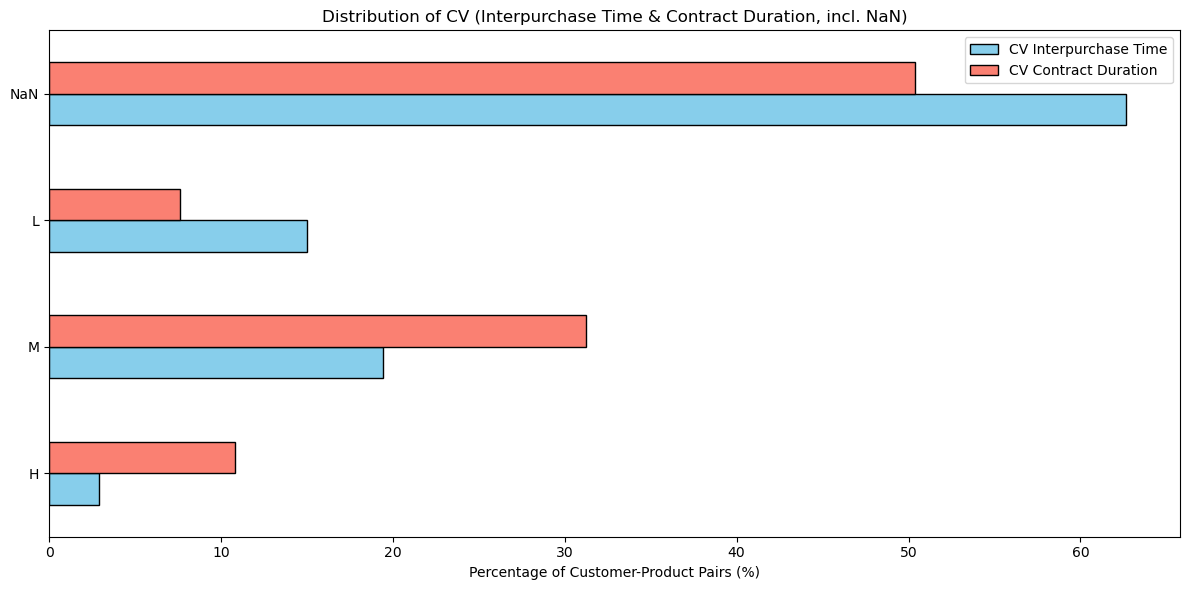

     CV Interpurchase Time  CV Contract Duration
H                     2.90                 10.79
M                    19.45                 31.21
L                    14.99                  7.62
NaN                  62.66                 50.38


In [30]:
import matplotlib.pyplot as plt

# Count the distribution of CV_Interpurchase_Time_custprod, including NaN as a separate category
cv_series = time_regularity_custprod["CV_Interpurchase_Time_custprod"]
cv_bins = [-0.01, 0.5, 1.5, float('inf')]
cv_labels = ["H", "M", "L"]

# Bin the non-null values for interpurchase time
cv_binned = pd.cut(cv_series.dropna(), bins=cv_bins, labels=cv_labels, include_lowest=True)
cv_dist = cv_binned.value_counts().sort_index()
null_count = cv_series.isna().sum()
cv_dist_with_null = cv_dist.append(pd.Series({"NaN": null_count}))
cv_dist_pct = (cv_dist_with_null / cv_dist_with_null.sum()) * 100

# Do the same for CV_Contract_Duration_custprod
qty_cv_series = quantity_regularity_custprod["CV_Contract_Duration_custprod"]
qty_cv_binned = pd.cut(qty_cv_series.dropna(), bins=cv_bins, labels=cv_labels, include_lowest=True)
qty_cv_dist = qty_cv_binned.value_counts().sort_index()
qty_null_count = qty_cv_series.isna().sum()
qty_cv_dist_with_null = qty_cv_dist.append(pd.Series({"NaN": qty_null_count}))
qty_cv_dist_pct = (qty_cv_dist_with_null / qty_cv_dist_with_null.sum()) * 100

# Combine into a DataFrame for grouped barh plot
cv_dist_df = pd.DataFrame({
    "CV Interpurchase Time": cv_dist_pct,
    "CV Contract Duration": qty_cv_dist_pct
}).fillna(0)

# Plot grouped horizontal bars
cv_dist_df.plot(kind="barh", figsize=(12, 6), color=["skyblue", "salmon"], edgecolor="black")
plt.xlabel("Percentage of Customer-Product Pairs (%)")
plt.title("Distribution of CV (Interpurchase Time & Contract Duration, incl. NaN)")
plt.tight_layout()
plt.show()

print(cv_dist_df.round(2))

ANALYSIS QUESTION:  
Do customers rent consistently over time and duration — and can we identify behavioral patterns that support better forecasting, retention strategies, or contract design?

DATA FINDING:  
The average interpurchase time for most customer–product pairs falls between 0–200 days, with a clear peak at 0–30 days—indicating frequent short-term renewals or prompt reorders after annual contracts end. Comparing regularity metrics, interpurchase time shows high variability (CV up to 8), meaning customers repurchase unpredictably. In contrast, contract duration is more consistent (CV ≤ 2), suggesting customers usually plan how long they need a product, even if the timing of their next rental varies. This reflects structured project timelines versus irregular project cycles.

INSIGHTS:  
This shows that customers have more regular behavior when it comes to quantity regularity and are less confident about when they want to have the next contract (i.e. they have more diversified interpurchase time). medium regularity in both variables of quantity and time regularity is the highest rate if we disregard one/two time purchases. when calculating the regularity for both variables in customer-product level, one or two times purchases account to 50-60 of them showing that most of the customers rent only 1-2 times and disappear. this is an important warning for the company to plan for a new retention strategy. 


FINDING A CORRELATION BETWEEN TIME REGULARITY AND QUANTITY REGULARIRTY

ANALYSIS QUESTION:  
When considering time and quantity regularity as two of the most important parameters that determine the behavor of  the customer, one might wonder if there is a relationship between the two or if one can explain the other one. 

DATA FINDING:  
Looking at the scatter plot below we can see that there is little collinearity between the two

INSIGHT:  
the cv of the time between two contracts and the cv of the contract duration have to connection in terms of one can predict of define the other one. so if the company plan to stimulate a more regular behavior, it's not a good idea to improve one of these metrics by the other one. 

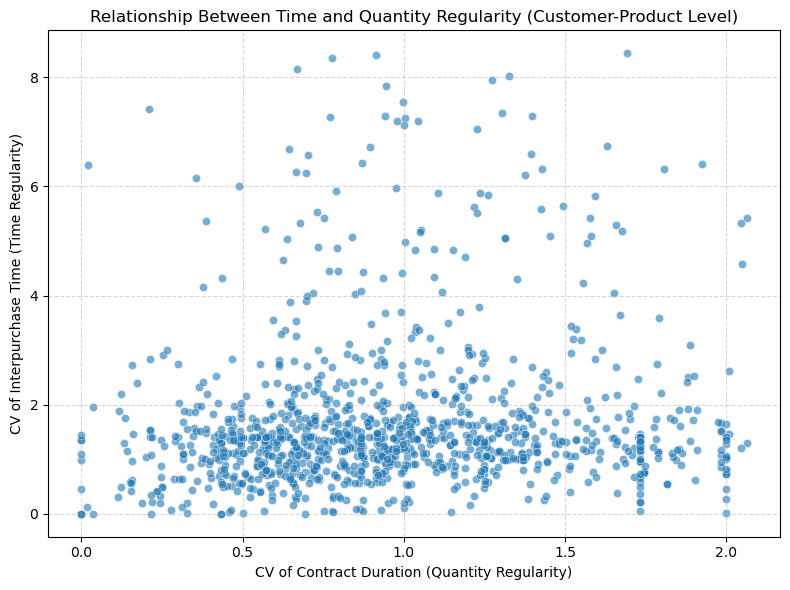

In [31]:
import seaborn as sns

import matplotlib.pyplot as plt

# Merge time_regularity_custprod and quantity_regularity on Customer ID and Product Group
reg_data = time_regularity_custprod.merge(
    quantity_regularity_custprod[["Customer ID", "Product Group", "CV_Contract_Duration_custprod"]],
    on=["Customer ID", "Product Group"],
    how="inner"
)

# Remove outliers: keep only rows where both CVs are below the 95th percentile
reg_duration_95 = reg_data["CV_Contract_Duration_custprod"].quantile(0.95)
reg_time_95 = reg_data["CV_Interpurchase_Time_custprod"].quantile(0.95)
reg_data_zoom = reg_data[
    (reg_data["CV_Contract_Duration_custprod"] <= reg_duration_95) &
    (reg_data["CV_Interpurchase_Time_custprod"] <= reg_time_95)
]

# Drop rows with missing values in either CV column
reg_data_zoom = reg_data_zoom.dropna(subset=["CV_Interpurchase_Time_custprod", "CV_Contract_Duration_custprod"])

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=reg_data_zoom,
    x="CV_Contract_Duration_custprod",
    y="CV_Interpurchase_Time_custprod",
    alpha=0.6
)
plt.xlabel("CV of Contract Duration (Quantity Regularity)")
plt.ylabel("CV of Interpurchase Time (Time Regularity)")
plt.title("Relationship Between Time and Quantity Regularity (Customer-Product Level)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [32]:
# Merge Quantity_Regularity_Score into reg_data if not already present
if "Quantity_Regularity_Score" not in reg_data.columns:
    reg_data = reg_data.merge(
        quantity_regularity_custprod[["Customer ID", "Product Group", "Quantity_Regularity_Score"]],
        on=["Customer ID", "Product Group"],
        how="left"
    )

# Remove rows where either Time_Regularity_Score or Quantity_Regularity_Score is "No regularity"
reg_data = reg_data[
    (reg_data["Time_Regularity_Score"] != "No regularity") &
    (reg_data["Quantity_Regularity_Score"] != "No regularity")
].copy()

# Convert scores to integers if they are not already
reg_data["Time_Regularity_Score"] = reg_data["Time_Regularity_Score"].astype(int)
reg_data["Quantity_Regularity_Score"] = reg_data["Quantity_Regularity_Score"].astype(int)

# Calculate the combined regularity score as the product of the two scores
reg_data["Combined_Regularity_Score"] = (
    reg_data["Time_Regularity_Score"] * reg_data["Quantity_Regularity_Score"]
)

print(reg_data[[
    "Customer ID", "Product Group", "Time_Regularity_Score", "Quantity_Regularity_Score", "Combined_Regularity_Score"
]].head())

   Customer ID            Product Group  Time_Regularity_Score  \
5       cust02             Telehandlers                      3   
6       cust02  Truck Mounted Platforms                      2   
7       cust02           Vertical Lifts                      2   
8       cust03                Rent Vans                      1   
12      cust05      Rotating Boom Lifts                      2   

    Quantity_Regularity_Score  Combined_Regularity_Score  
5                           2                          6  
6                           1                          2  
7                           2                          4  
8                           1                          1  
12                          2                          4  


In [33]:
# Combined_Regularity_Score count
score_counts = reg_data["Combined_Regularity_Score"].value_counts().sort_index()

# Show value counts as a table
print(score_counts)

1    119
2    512
3     65
4    432
6    141
9     32
Name: Combined_Regularity_Score, dtype: int64


In [34]:
# Assign labels to Combined_Regularity_Score in reg_data
def combined_regularity_label(score):
    if score >= 6:
        return "H"
    elif score >= 3:
        return "M"
    else:
        return "L"

reg_data["Combined_Regularity_Label"] = reg_data["Combined_Regularity_Score"].apply(combined_regularity_label)

print(reg_data[["Customer ID", "Product Group", "Combined_Regularity_Score", "Combined_Regularity_Label"]].head())

   Customer ID            Product Group  Combined_Regularity_Score  \
5       cust02             Telehandlers                          6   
6       cust02  Truck Mounted Platforms                          2   
7       cust02           Vertical Lifts                          4   
8       cust03                Rent Vans                          1   
12      cust05      Rotating Boom Lifts                          4   

   Combined_Regularity_Label  
5                          H  
6                          L  
7                          M  
8                          L  
12                         M  


RFM Analysis - (customer-Product perspecitve)

We applied RFM scoring per customer–product group, treating each pair as a unique behavior unit. 
Monetary was calculated using the average spend per product, minimizing size bias and reducing collinearity with frequency. 
Recency was based on the number of days since the last contract ended, using January 1, 2025 as the reference point. Negative recency values indicate ongoing contracts, helping us identify active, long-term customers versus those who may need reactivation.
Frequecny was calcualted as the number of unique contracts (Order ID) per customer-product. 

In [35]:
## Creating variables for RFM analysis
# Monetary: Average Amount per customer-product
# Compute Monetary on the full DataFrame
df["Monetary"] = (
    df
    .groupby(["Customer ID", "Product Group"])["Amount"]
    .transform("mean")
)

# Drop all rows where that computed Monetary is zero
df = df[df["Monetary"] > 0].copy()

In [36]:
# Frequency: Count of unique rental events per customer-product
df["Frequency"] = df.groupby(["Customer ID", "Product Group"])["Order ID"].transform("count")

In [37]:
# Recency: the time since the last purchase
from datetime import timedelta

# Ensure datetime format
df["Factor Date"] = pd.to_datetime(df["Factor Date"])
df["End of rental"] = pd.to_datetime(df["End of rental"])

# Define the fixed reference date for the entire dataset
reference_date = df["Factor Date"].max() + timedelta(days=1)

# Get the latest End of rental per customer-product pair
last_End_of_rental = (
    df.groupby(["Customer ID", "Product Group"])["End of rental"]
    .max()
    .reset_index()
)

# Calculate Recency
last_End_of_rental["Recency"] = (reference_date - last_End_of_rental["End of rental"]).dt.days

# If End of rental is in the future, make Recency negative
last_End_of_rental["Recency"] = np.where(
    last_End_of_rental["End of rental"] > reference_date,
    -(last_End_of_rental["End of rental"] - reference_date).dt.days,
    last_End_of_rental["Recency"]
)

# Merge recency back to the main dataset
df = df.merge(
    last_End_of_rental[["Customer ID", "Product Group", "Recency"]],
    on=["Customer ID", "Product Group"],
    how="left"
)

# Quick sanity check
print(f"Reference Date used for Recency: {reference_date.date()}")
cols_to_show = [col for col in ["Customer ID", "Product Group", "End of rental", "Recency"] if col in df.columns]
print(df[cols_to_show].head())

Reference Date used for Recency: 2025-01-01
  Customer ID   Product Group End of rental  Recency
0      cust01  Rent Outfitted    2021-04-01     1371
1      cust02    Rent Special    2021-03-09     1394
2      cust03       Rent Vans    2022-01-21      478
3      cust04       Rent Vans    2021-06-18     1293
4      cust05       Rent Vans    2021-02-11     1420


In [38]:
# testing if the values have been created correctly
df_rfm = df.groupby(["Customer ID", "Product Group"])[
    ["Recency", "Frequency", "Monetary"]
].first().reset_index()

df_rfm.head(10)

,Customer ID,Product Group,Recency,Frequency,Monetary
0,cust01,Rent Outfitted,1371,5,837.200000
1,cust02,Rent Special,1394,3,1133.333333
2,cust02,Rotating Boom Lifts,1148,2,180.000000
3,cust02,Subrental Vehicles,978,7,477.608571
4,cust02,Telehandlers,950,3,590.000000
5,cust02,Truck Mounted Platforms,645,3,140.000000
6,cust02,Vertical Lifts,831,3,130.000000
7,cust03,Rent Vans,478,58,503.978621
8,cust04,Rent Vans,1293,6,886.676667
9,cust04,Rotating Boom Lifts,1042,1,630.000000


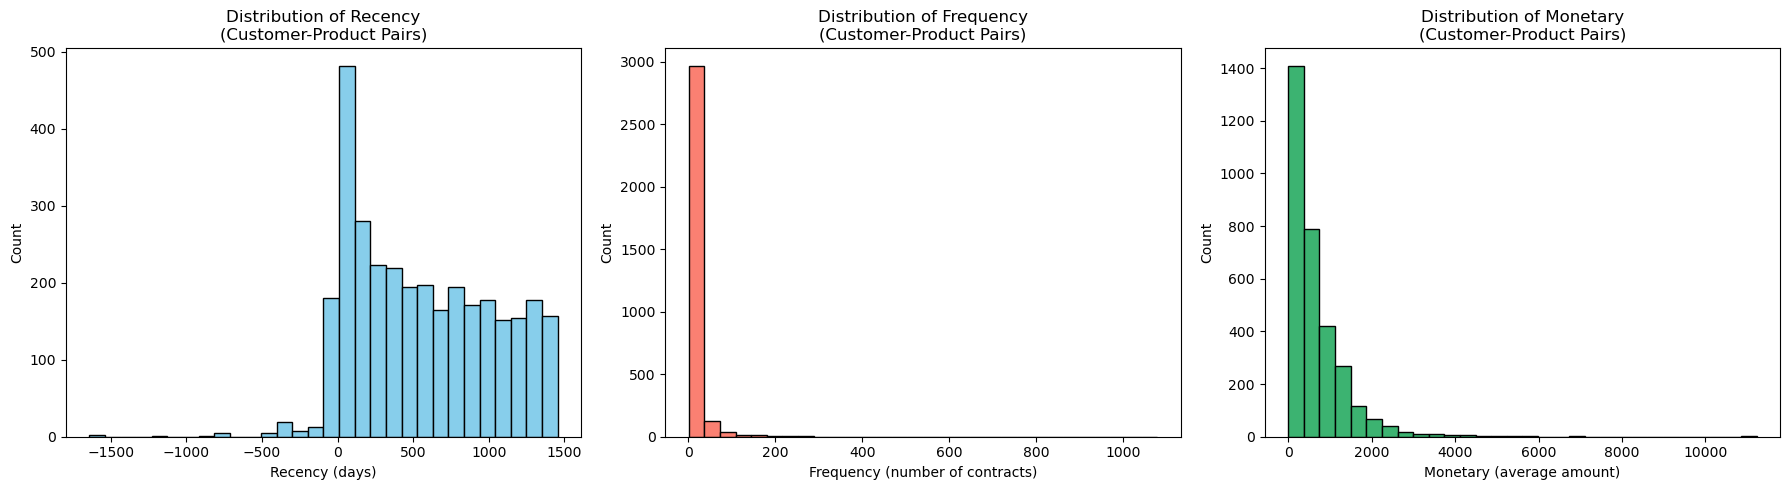

In [39]:
# Plot distributions for Recency, Frequency, and Monetary for customer-product pairs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency
axes[0].hist(df_rfm["Recency"].dropna(), bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("Distribution of Recency\n(Customer-Product Pairs)")
axes[0].set_xlabel("Recency (days)")
axes[0].set_ylabel("Count")

# Frequency
axes[1].hist(df_rfm["Frequency"].dropna(), bins=30, color='salmon', edgecolor='black')
axes[1].set_title("Distribution of Frequency\n(Customer-Product Pairs)")
axes[1].set_xlabel("Frequency (number of contracts)")
axes[1].set_ylabel("Count")

# Monetary
axes[2].hist(df_rfm["Monetary"].dropna(), bins=30, color='mediumseagreen', edgecolor='black')
axes[2].set_title("Distribution of Monetary\n(Customer-Product Pairs)")
axes[2].set_xlabel("Monetary (average amount)")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

Removing Anomalies from RFM scores:
to capture the anomalies in the RFM variables that we calculated, we detected anomalies by checking for unusually large jumps between high percentiles (95th–99th), using a helper function that flags any relative increase over 50%. Frequency showed no anomalies, but Monetary values had outliers with a threshold around 146.93. In total, 32 anomalous customer-product pairs were flagged and stored in a separate dataframe. 

In [40]:
# checking for anomalies in the RFM variables

# Calculate high percentiles for Frequency and Monetary
percentiles = {
    "p95_frequency": np.percentile(df_rfm["Frequency"].dropna(), 95),
    "p96_frequency": np.percentile(df_rfm["Frequency"].dropna(), 96),
    "p97_frequency": np.percentile(df_rfm["Frequency"].dropna(), 97),
    "p98_frequency": np.percentile(df_rfm["Frequency"].dropna(), 98),
    "p99_frequency": np.percentile(df_rfm["Frequency"].dropna(), 99),
    "p95_monetary": np.percentile(df_rfm["Monetary"].dropna(), 95),
    "p96_monetary": np.percentile(df_rfm["Monetary"].dropna(), 96),
    "p97_monetary": np.percentile(df_rfm["Monetary"].dropna(), 97),
    "p98_monetary": np.percentile(df_rfm["Monetary"].dropna(), 98),
    "p99_monetary": np.percentile(df_rfm["Monetary"].dropna(), 99),
}

# Helper function to detect large differences between consecutive percentiles
def check_anomaly_threshold(values):
    values = np.array(values)
    diffs = np.diff(values)
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_diffs = np.where(values[:-1] != 0, diffs / values[:-1], 0)
    return np.any(rel_diffs > 0.5)

# Extract frequency and monetary percentiles
frequency_percentiles = [
    percentiles["p95_frequency"], percentiles["p96_frequency"], percentiles["p97_frequency"],
    percentiles["p98_frequency"], percentiles["p99_frequency"]
]
monetary_percentiles = [
    percentiles["p95_monetary"], percentiles["p96_monetary"], percentiles["p97_monetary"],
    percentiles["p98_monetary"], percentiles["p99_monetary"]
]

# Calculate anomaly thresholds for frequency and monetary metrics
frequency_threshold = frequency_percentiles[-1] if check_anomaly_threshold(frequency_percentiles) else None
monetary_threshold = monetary_percentiles[-1] if check_anomaly_threshold(monetary_percentiles) else None

# Display frequency threshold
if frequency_threshold is None:
    print("No anomalies detected in frequency. Threshold set to None.")
else:
    print(f"Frequency anomaly threshold: {frequency_threshold:.2f}")

# Display monetary threshold
if monetary_threshold is None:
    print("No anomalies detected in monetary metric. Threshold set to None.")
else:
    print(f"Monetary anomaly threshold: {monetary_threshold:.2f}")

Frequency anomaly threshold: 146.27
No anomalies detected in monetary metric. Threshold set to None.


In [41]:
# Identify Anomalous Customers
# Detect anomalies based on frequency and monetary thresholds

# Add anomaly label
def anomaly_label(row):
    if frequency_threshold is not None and row["Frequency"] > frequency_threshold:
        return "frequency"
    if monetary_threshold is not None and row["Monetary"] > monetary_threshold:
        return "monetary"
    return None

rfm_anomaly = df_rfm[
    ((frequency_threshold is not None) & (df_rfm["Frequency"] > frequency_threshold)) |
    ((monetary_threshold is not None) & (df_rfm["Monetary"] > monetary_threshold))
].copy()

rfm_anomaly["anomaly"] = rfm_anomaly.apply(anomaly_label, axis=1)

print(f"Number of anomalies detected: {len(rfm_anomaly)}")
rfm_anomaly.head()

print(f"Original rows: {len(df_rfm)}")


Number of anomalies detected: 32
Original rows: 3174


In [42]:
# Remove anomalous customers from df_rfm
df_rfm = df_rfm[~df_rfm["Customer ID"].isin(rfm_anomaly["Customer ID"])]

print(f"Original rows: {len(df_rfm)}")
print(f"Rows after removing anomalies: {len(df_rfm)}")


Original rows: 3027
Rows after removing anomalies: 3027


RFM Scoring (Customer-Product)

After removing the outliers, we assigned a score from 1 to 5 to each of the RFM components using the quantile method. Starting with Recency, we first replaced any negative values with zero, treating them as if no time has elapsed since the last purchase. In RFM scoring, higher Recency values indicate a longer time since the last purchase, which is considered less favorable—therefore, higher Recency corresponds to lower scores. Conversely, a Recency value of zero receives the highest score.

In [43]:
# R, F, M Scoring (1-5) using manual quantile thresholds

# Cap negative recency to zero
df_rfm['Recency_Capped'] = df_rfm['Recency'].clip(lower=0)

# Compute quantile thresholds
recency_quants = df_rfm['Recency_Capped'].quantile([0.2, 0.4, 0.6, 0.8]).values
frequency_quants = df_rfm['Frequency'].quantile([0.2, 0.4, 0.6, 0.8]).values
monetary_quants = df_rfm['Monetary'].quantile([0.2, 0.4, 0.6, 0.8]).values

# R Score: lower recency = higher score
def r_score(x):
    if x <= recency_quants[0]:
        return 5
    elif x <= recency_quants[1]:
        return 4
    elif x <= recency_quants[2]:
        return 3
    elif x <= recency_quants[3]:
        return 2
    else:
        return 1

# F Score: higher frequency = higher score
def f_score(x):
    if x <= frequency_quants[0]:
        return 1
    elif x <= frequency_quants[1]:
        return 2
    elif x <= frequency_quants[2]:
        return 3
    elif x <= frequency_quants[3]:
        return 4
    else:
        return 5

# M Score: higher monetary = higher score
def m_score(x):
    if x <= monetary_quants[0]:
        return 1
    elif x <= monetary_quants[1]:
        return 2
    elif x <= monetary_quants[2]:
        return 3
    elif x <= monetary_quants[3]:
        return 4
    else:
        return 5

df_rfm['R_Score'] = df_rfm['Recency_Capped'].apply(r_score)
df_rfm['F_Score'] = df_rfm['Frequency'].apply(f_score)
df_rfm['M_Score'] = df_rfm['Monetary'].apply(m_score)

df_rfm.drop(columns=['Recency_Capped'], inplace=True)

print(df_rfm[['Customer ID', 'Product Group', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score']].head(10))

  Customer ID            Product Group  Recency  Frequency     Monetary  \
0      cust01           Rent Outfitted     1371          5   837.200000   
1      cust02             Rent Special     1394          3  1133.333333   
2      cust02      Rotating Boom Lifts     1148          2   180.000000   
3      cust02       Subrental Vehicles      978          7   477.608571   
4      cust02             Telehandlers      950          3   590.000000   
5      cust02  Truck Mounted Platforms      645          3   140.000000   
6      cust02           Vertical Lifts      831          3   130.000000   
7      cust03                Rent Vans      478         58   503.978621   
8      cust04                Rent Vans     1293          6   886.676667   
9      cust04      Rotating Boom Lifts     1042          1   630.000000   

   R_Score  F_Score  M_Score  
0        1        4        4  
1        1        3        5  
2        1        2        2  
3        2        4        3  
4        2        3

Clustering

To segment customers more effectively, we used two RFM dimensions—Frequency and Monetary—to define a Size metric for each customer–product pair: Size = F_Score × M_Score. This was categorized into Low, Medium, and High using 33rd and 67th percentiles. To incorporate behavioral consistency, we created a Combined Regularity score by multiplying time and quantity regularity scores, and labeled it as High (≥6), Medium (3–6), or Low (<3). This dual segmentation captures both revenue potential and rental behavior, enabling more tailored strategies per product line. Since customers often behave differently across products, this method ensures marketing actions reflect their true, product-specific engagement.

In [44]:
# assign Size score based on F, M scores
df_rfm['Size'] = df_rfm['F_Score'] * df_rfm['M_Score']
# Assign Size_Label based on the Size score (L=low, M=medium, H=high)
size_quants = df_rfm['Size'].quantile([0.33, 0.67]).values

def size_label(x):
    if x <= size_quants[0]:
        return "L"
    elif x <= size_quants[1]:
        return "M"
    else:
        return "H"

df_rfm['Size_Label'] = df_rfm['Size'].apply(size_label)

print(df_rfm[['Customer ID', 'Product Group', 'F_Score', 'M_Score', 'Size', 'Size_Label']].head(10))

  Customer ID            Product Group  F_Score  M_Score  Size Size_Label
0      cust01           Rent Outfitted        4        4    16          H
1      cust02             Rent Special        3        5    15          H
2      cust02      Rotating Boom Lifts        2        2     4          L
3      cust02       Subrental Vehicles        4        3    12          H
4      cust02             Telehandlers        3        4    12          H
5      cust02  Truck Mounted Platforms        3        1     3          L
6      cust02           Vertical Lifts        3        1     3          L
7      cust03                Rent Vans        5        3    15          H
8      cust04                Rent Vans        4        4    16          H
9      cust04      Rotating Boom Lifts        1        4     4          L


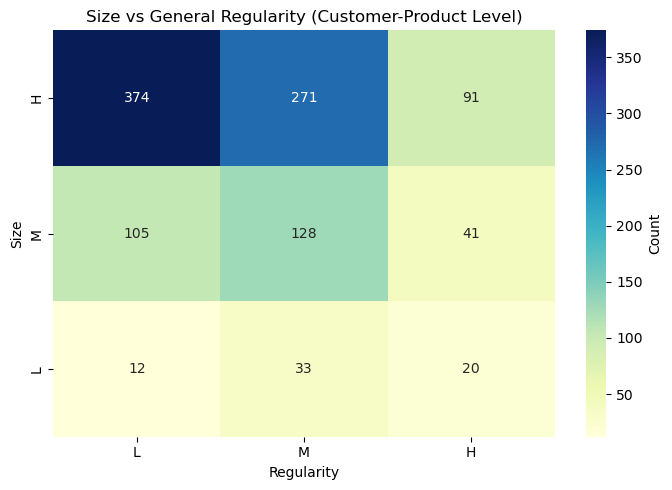

In [45]:
# Merge combined_regularity_Label from quantity_regularity into df_rfm to create rfm_reg
rfm_reg = df_rfm.merge(
    reg_data[["Customer ID", "Product Group", "Combined_Regularity_Label"]],
    on=["Customer ID", "Product Group"],
    how="left"
)

# Count the number of customer-product pairs for each (Size_Label, Combined_Regularity_Label) combination
heatmap_data = (
    rfm_reg.groupby(["Size_Label", "Combined_Regularity_Label"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=["H", "M", "L"], columns=["L", "M", "H"])
)

plt.figure(figsize=(7, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar_kws={'label': 'Count'}
)
plt.xlabel("Regularity")
plt.ylabel("Size")
plt.title("Size vs General Regularity (Customer-Product Level)")
plt.tight_layout()
plt.show()


ANALYSIS QUESTION: 
Do high-value customer–product pairs also exhibit regular purchasing behavior, and can this relationship be used to predict future rentals or guide targeted retention strategies?

DATA FINDING:  
Understanding how Size (purchasing power) relates to regularity helps us predict customer behavior—especially whether high-value customers return consistently. To investigate this, we plotted a heatmap using Size and combined regularity labels, revealing distinct behavioral clusters. Null values were removed beforehand to ensure clean segmentation based on reliable time and quantity patterns.

INSIGHTS:  
Following this logic, we defined 5 clusters from the heatmap of Regularity and Size based on the behavior that they imply which is defined below:   
•	When Regularity Label is M or H and Size Label is H Or Regularity Label is H and Size Label is M = "Top Customers"
•	When Regularity Label is "L" and Size Label is "H" = " Butterflies"
•	When Regularity Label is "L" or "M" and Size Label is "M" = "Moderators"
•	When Regularity Label is "L" or "M" and Size Label is "L" = "Low Engagers"
•	When Regularity Label is "H" and Size Label is "L" = "Questionables"

In [46]:
def cluster_descr(row):
    if (
        (row["Combined_Regularity_Label"] in ["M", "H"] and row["Size_Label"] == "H")
        or (row["Combined_Regularity_Label"] == "H" and row["Size_Label"] == "M")
    ):
        return "Top Customers"
    elif row["Combined_Regularity_Label"] in ["L"] and row["Size_Label"] == "H":
        return "Butterflies"
    elif row["Combined_Regularity_Label"] in ["L", "M"] and row["Size_Label"] == "M":
        return "Moderators"
    elif row["Combined_Regularity_Label"] in ["L", "M"] and row["Size_Label"] == "L":
        return "Low Engagers"
    elif row["Combined_Regularity_Label"] in ["H"] and row["Size_Label"] == "L":
        return "Questionables"
    else:
        return None

# remove rows where Combined_Regularity_Label or Size_Label is NaN
rfm_reg = rfm_reg.dropna(subset=["Combined_Regularity_Label", "Size_Label"])

rfm_reg["Cluster_Label"] = rfm_reg.apply(cluster_descr, axis=1)
print(rfm_reg[["Customer ID", "Product Group", "Size_Label", "Combined_Regularity_Label", "Cluster_Label"]].head(10))

   Customer ID            Product Group Size_Label Combined_Regularity_Label  \
4       cust02             Telehandlers          H                         H   
5       cust02  Truck Mounted Platforms          L                         L   
6       cust02           Vertical Lifts          L                         M   
7       cust03                Rent Vans          H                         L   
11      cust05      Rotating Boom Lifts          H                         M   
12      cust05  Truck Mounted Platforms          H                         M   
13      cust06           Rent Outfitted          H                         L   
14      cust06                Rent Vans          H                         M   
15      cust06      Rotating Boom Lifts          H                         L   
16      cust06  Truck Mounted Platforms          M                         L   

    Cluster_Label  
4   Top Customers  
5    Low Engagers  
6    Low Engagers  
7     Butterflies  
11  Top Customers  

In [47]:
# Sanity-check: show each (Size, Regularity) pair once with its assigned label
pd.DataFrame(
    [(size, reg, cluster_descr(pd.Series({
         "Size_Label": size,
         "Combined_Regularity_Label": reg
    })))
     for size in ["H","M","L"]
     for reg in ["L","M","H"]],
    columns=["Size_Label", "Combined_Regularity_Label", "Cluster_Label"]
)

,Size_Label,Combined_Regularity_Label,Cluster_Label
0,H,L,Butterflies
1,H,M,Top Customers
2,H,H,Top Customers
3,M,L,Moderators
4,M,M,Moderators
5,M,H,Top Customers
6,L,L,Low Engagers
7,L,M,Low Engagers
8,L,H,Questionables


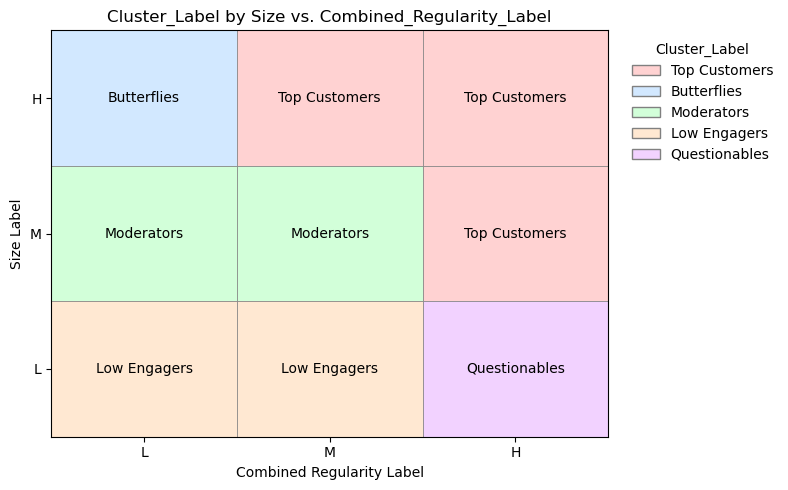

In [48]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Use the existing y_order and x_order variables
y_order = ["H", "M", "L"]
x_order = ["L", "M", "H"]

import pandas as pd

def cluster_descr(row):
    if (
        (row["Combined_Regularity_Label"] in ["M", "H"] and row["Size_Label"] == "H")
        or (row["Combined_Regularity_Label"] == "H" and row["Size_Label"] == "M")
    ):
        return "Top Customers"
    elif row["Combined_Regularity_Label"] in ["L"] and row["Size_Label"] == "H":
        return "Butterflies"
    elif row["Combined_Regularity_Label"] in ["L", "M"] and row["Size_Label"] == "M":
        return "Moderators"
    elif row["Combined_Regularity_Label"] in ["L", "M"] and row["Size_Label"] == "L":
        return "Low Engagers"
    elif row["Combined_Regularity_Label"] in ["H"] and row["Size_Label"] == "L":
        return "Questionables"
    else:
        return None

# Create the matrix of cluster labels
cluster_matrix = pd.DataFrame(
    [
        [cluster_descr(pd.Series({"Size_Label": size, "Combined_Regularity_Label": reg})) for reg in x_order]
        for size in y_order
    ],
    index=y_order,
    columns=x_order
)

# Assign light colors to each cluster label
cluster_to_color = {
    "Top Customers":  "#ffd2d2",  # light red
    "Butterflies":    "#d2e8ff",  # light blue
    "Moderators":     "#d2ffd9",  # light green
    "Low Engagers":   "#ffe8d2",  # light orange
    "Questionables":  "#f2d2ff",  # light purple
    "":               "#ffffff"   # blank
}
fig, ax = plt.subplots(figsize=(8, 5))

for i, size in enumerate(y_order):
    for j, reg in enumerate(x_order):
        label = cluster_matrix.at[size, reg]
        color = cluster_to_color.get(label, "#FFFFFF")
        ax.add_patch(plt.Rectangle(
            (j - 0.5, i - 0.5), 1, 1,
            facecolor=color, edgecolor="gray", linewidth=0.5
        ))
        ax.text(
            j, i, label if label else "",
            ha="center", va="center",
            fontsize=10, color="black", wrap=True
        )

ax.set_xlim(-0.5, len(x_order) - 0.5)
ax.set_ylim(len(y_order) - 0.5, -0.5)
ax.set_xticks(range(len(x_order)))
ax.set_xticklabels(x_order)
ax.set_yticks(range(len(y_order)))
ax.set_yticklabels(y_order)
ax.set_xlabel("Combined Regularity Label")
ax.set_ylabel("Size Label")
ax.set_title("Cluster_Label by Size vs. Combined_Regularity_Label")

handles = [
    Patch(facecolor=col, edgecolor="gray", label=cl)
    for cl, col in cluster_to_color.items() if cl
]
ax.legend(handles=handles,
          title="Cluster_Label",
          bbox_to_anchor=(1.02, 1),
          loc="upper left",
          frameon=False)

plt.tight_layout()
plt.show()


ANALYSIS QUESTION:  
Are the defined clusters significanlty different from each other? 

DATA FINDING:  
To confirm that the clusters represent distinct customer behaviors, we conducted a one-way ANOVA on Size and Combined Regularity Score. This test evaluates whether the average values of these metrics differ significantly across clusters. The results showed p-values well below 0.05 for both variables, indicating that the clusters are statistically distinct and reflect meaningful differences in customer behavior. This validates the segmentation and supports its use for targeted strategies.

In [49]:
import pandas as pd
from scipy.stats import f_oneway

# 1) Ensure no missing cluster labels
rfm_reg_clean = rfm_reg.dropna(subset=['Cluster_Label'])

# Merge Combined_Regularity_Score from reg_data if not already present
if "Combined_Regularity_Score" not in rfm_reg_clean.columns:
	rfm_reg_clean = rfm_reg_clean.merge(
		reg_data[["Customer ID", "Product Group", "Combined_Regularity_Score"]],
		on=["Customer ID", "Product Group"],
		how="left"
	)

# 2) Group by cluster descriptor
groups = list(rfm_reg_clean.groupby('Cluster_Label'))

# 3) ANOVA for Size
size_groups = [group['Size'].values for name, group in groups]
anova_size = f_oneway(*size_groups)
print(">>> ANOVA Results for Size:")
print(f"F-statistic: {anova_size.statistic:.6f}, p-value: {anova_size.pvalue:.8f}")
print("- If the p-value is < 0.05, clusters differ significantly in size.\n")

# 4) ANOVA for Combined Regularity
reg_groups = [group['Combined_Regularity_Score'].values for name, group in groups]
anova_reg = f_oneway(*reg_groups)
print(">>> ANOVA Results for Combined Regularity:")
print(f"F-statistic: {anova_reg.statistic:.6f}, p-value: {anova_reg.pvalue:.8f}")
print("- If the p-value is < 0.05, clusters differ significantly in combined regularity.\n")

>>> ANOVA Results for Size:
F-statistic: 411.948169, p-value: 0.00000000
- If the p-value is < 0.05, clusters differ significantly in size.

>>> ANOVA Results for Combined Regularity:
F-statistic: 421.587333, p-value: 0.00000000
- If the p-value is < 0.05, clusters differ significantly in combined regularity.



RFM Variables Distribution Among Clusters

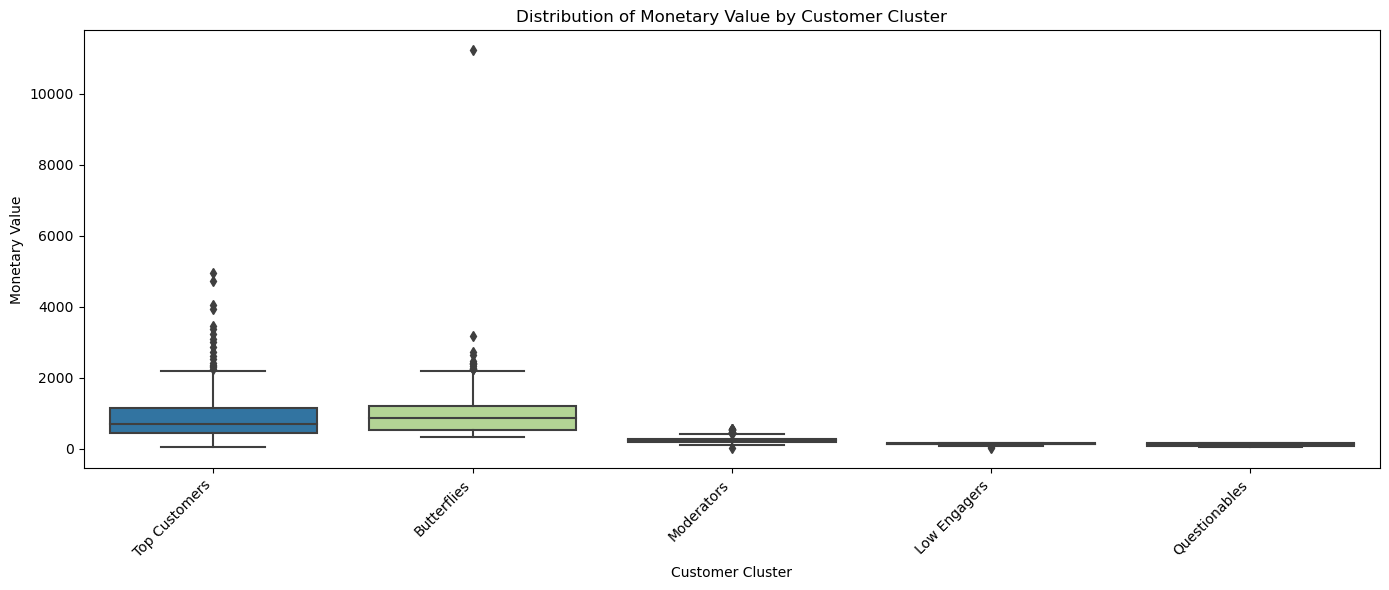

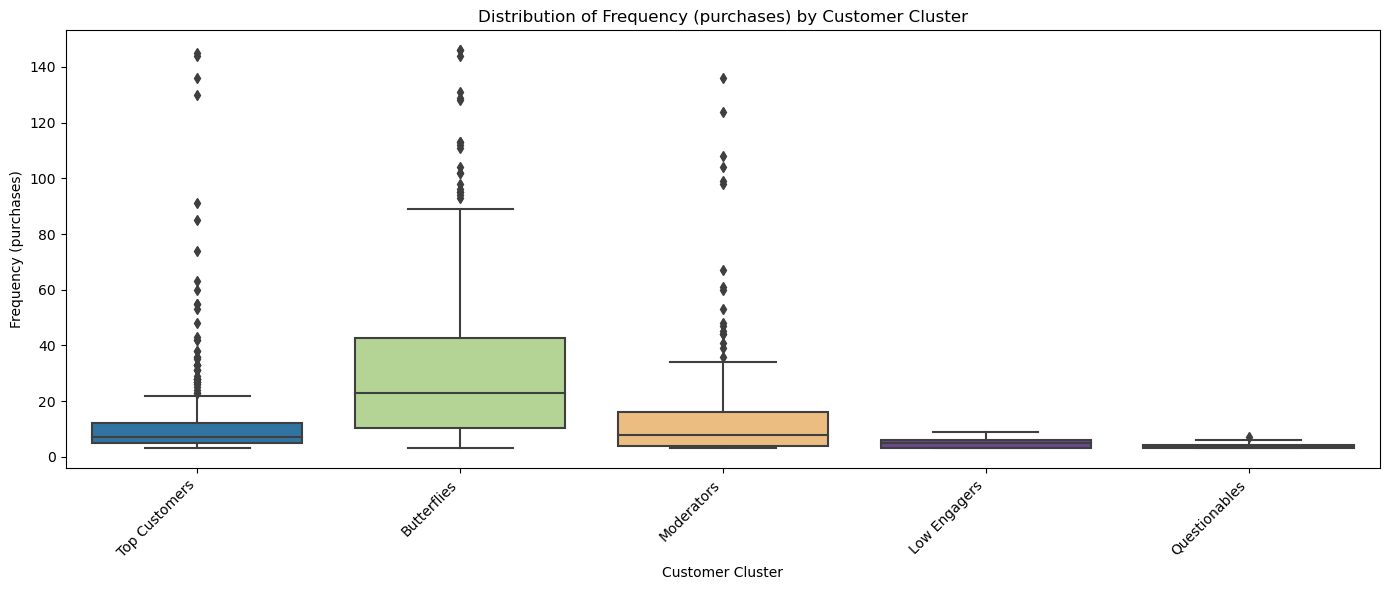

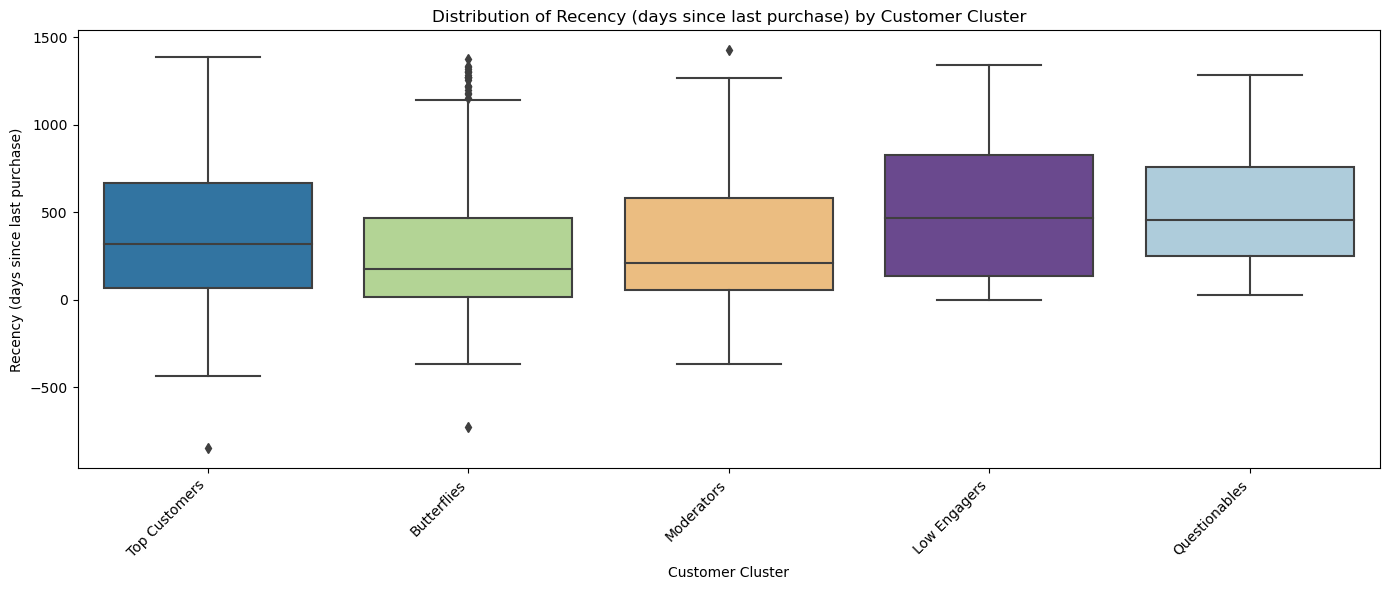

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the ordered clusters and their colors
ordered_clusters = [
    "Top Customers", "Butterflies", "Moderators",
    "Low Engagers", "Questionables"]
custom_colors = {
    "Top Customers": "#1f78b4",
    "Butterflies": "#b2df8a",
    "Moderators":  "#fdbf6f",
    "Low Engagers": "#6a3d9a",
    "Questionables": "#a6cee3",
}

# 2. Make "Cluster_Label" a categorical with the specified order
rfm_reg["Cluster_Label"] = pd.Categorical(
    rfm_reg["Cluster_Label"],
    categories=ordered_clusters,
    ordered=True
)

# 3. Function to draw a boxplot for a given metric
def draw_boxplot(metric, ylabel):
    plt.figure(figsize=(14, 6))
    sns.boxplot(
        data=rfm_reg,
        x="Cluster_Label",
        y=metric,
        order=ordered_clusters,
        palette=custom_colors
    )
    plt.title(f"Distribution of {ylabel} by Customer Cluster")
    plt.xlabel("Customer Cluster")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 4. Plot Monetary, Frequency and Recency
draw_boxplot('Monetary', 'Monetary Value')
draw_boxplot('Frequency', 'Frequency (purchases)')
draw_boxplot('Recency', 'Recency (days since last purchase)')


Distribution of Customer Clusters

Top Customers    403
Butterflies      374
Moderators       233
Low Engagers      45
Questionables     20
Name: Cluster_Label, dtype: int64


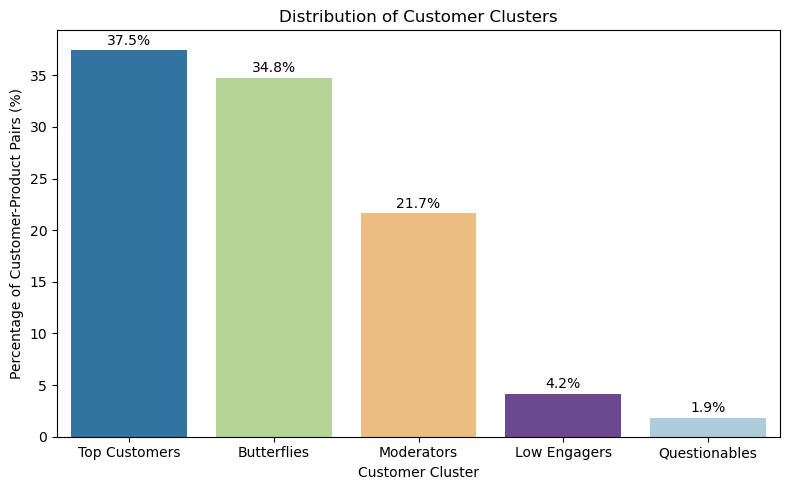

In [51]:
# Count the number of customer-product pairs in each cluster
cluster_counts = rfm_reg["Cluster_Label"].value_counts().sort_index()
print(cluster_counts)

# Plot the distribution of clusters in percentage
plt.figure(figsize=(8, 5))
sns.barplot(
    x=cluster_counts.index,
    y=cluster_counts.values / cluster_counts.sum() * 100,
    palette=custom_colors
)
plt.title("Distribution of Customer Clusters")
plt.xlabel("Customer Cluster")
plt.ylabel("Percentage of Customer-Product Pairs (%)")
plt.tight_layout()

# SHOW THE PERCENtage VALUES on the bars
for i, count in enumerate(cluster_counts):
    plt.text(i, count / cluster_counts.sum() * 100 + 0.5, f"{count / cluster_counts.sum() * 100:.1f}%", ha='center')
plt.show()

ANALYSIS QUESTION:   
How are customer–product pairs distributed across behavioral clusters, and what does this reveal about the company’s customer base composition?

DATA FINDING:  
A bar chart shows that the Top Customers cluster contains the largest share of customer–product pairs. Together with the Butterflies, these two clusters represent over 72% of all observations, largely because they include a wide range of Size and Regularity combinations.The Moderators—customers with medium Size and regularity—make up about 21% of the population. Low Engagers and Questionables form the smallest, least active groups.

INSIGHT:  
The customer base is heavily concentrated in the high- or mid-value clusters, particularly among Top Customers and Butterflies, suggesting strong commercial potential.
However, the broad behavioral spread within these segments—especially among Butterflies—indicates a need for targeted retention and regularity-building efforts.
Smaller segments like Low Engagers could represent dormant potential or churn risks, but the core business momentum lies in activating and deepening engagement within the larger clusters.

Analysis of Dominant Product Groups by Customer Cluster

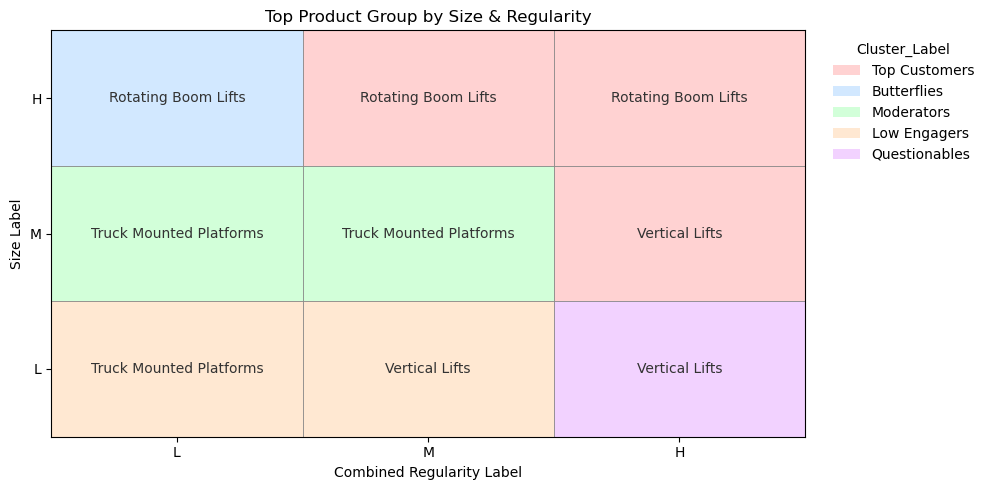

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1) Define axis order
x_order = ["L", "M", "H"]   # Combined_Regularity_Label
y_order = ["H", "M", "L"]   # Size_Label

# 2) Build two pivot-tables: 
#    a) top_prod: mode of Product Group
#    b) top_cluster: mode of Cluster_Label
top_prod = (
    pd.pivot_table(
        rfm_reg,
        index="Size_Label",
        columns="Combined_Regularity_Label",
        values="Product Group",
        aggfunc=lambda s: s.mode().iat[0] if not s.mode().empty else ""
    )
    .reindex(index=y_order, columns=x_order)
    .fillna("")
)

top_cluster = (
    pd.pivot_table(
        rfm_reg,
        index="Size_Label",
        columns="Combined_Regularity_Label",
        values="Cluster_Label",
        aggfunc=lambda s: s.mode().iat[0] if not s.mode().empty else ""
    )
    .reindex(index=y_order, columns=x_order)
    .fillna("")
)

# 3) Define colors for each cluster
cluster_to_color = {
    "Top Customers":  "#ffd2d2",  # light red
    "Butterflies":    "#d2e8ff",  # light blue
    "Moderators":     "#d2ffd9",  # light green
    "Low Engagers":   "#ffe8d2",  # light orange
    "Questionables":  "#f2d2ff",  # light purple
    "":               "#ffffff"   # blank
}

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 5))

for i, size in enumerate(y_order):
    for j, reg in enumerate(x_order):
        cluster = top_cluster.at[size, reg]
        prod     = top_prod.at[size, reg]
        # draw colored background
        ax.add_patch(plt.Rectangle(
            (j-0.5, i-0.5), 1, 1,
            facecolor=cluster_to_color.get(cluster, "#ffffff"),
            edgecolor="gray", linewidth=0.5
        ))
        # annotate with product group
        ax.text(
            j, i,
            prod or "",
            ha="center", va="center",
            fontsize=10, color="#333333",
            wrap=True
        )

# 5) Formatting
ax.set_xlim(-0.5, len(x_order)-0.5)
ax.set_ylim(len(y_order)-0.5, -0.5)
ax.set_xticks(range(len(x_order)))
ax.set_xticklabels(x_order)
ax.set_yticks(range(len(y_order)))
ax.set_yticklabels(y_order)
ax.set_xlabel("Combined Regularity Label")
ax.set_ylabel("Size Label")
ax.set_title("Top Product Group by Size & Regularity")

# 6) Legend
handles = [
    Patch(facecolor=c, label=lbl)
    for lbl, c in cluster_to_color.items() if lbl
]
ax.legend(handles=handles,
          title="Cluster_Label",
          bbox_to_anchor=(1.02, 1),
          loc="upper left",
          frameon=False)

plt.tight_layout()
plt.show()

Analysis of Dominant Product Groups by Customer Cluster

ANALYSIS QUESTION:  
How do product groups vary across customer segments defined by purchasing Size and Regularity, and what does this reveal about customer behavior and product positioning?

DATA FINDING:  
A heatmap crossing Size (L/M/H) and Regularity (L/M/H) shows dominant product groups per customer–product cluster. Rotating Boom Lifts consistently dominates all High-Size (H) segments, regardless of regularity, indicating strong association with high-spending, high-frequency customers. However, these customers show a wide range of regularity, from low to high, suggesting behavioral inconsistency despite financial importance. In Medium-Size (M) segments, Truck Mounted Platforms is the leading product—frequently rented but with short daily contracts, which lowers its average monetary value and Size classification.

INSIGHT:   
Rotating Boom Lifts is a strategic product with high revenue potential, but irregular usage patterns highlight an opportunity to nudge mid- and low-regularity customers (e.g., Butterflies) into more predictable cycles through incentives or scheduling tools.
Truck Mounted Platforms, while popular, suffers from short contract durations—implying room to grow revenue via mid- or long-term bundling strategies.
Combining RFM segmentation with regularity metrics reveals not just customer value but their behavioral reliability, enabling smarter product-specific retention and upsell plans.


In [53]:
## NOT CLASSIFIED Analysis ##

# checking if there are NOT CLASSIFIED group in the clusters

# Step 1: Filter the NOT CLASSIFIED group for analysis
# Check which cluster labels are present
print("Available cluster labels:", rfm_reg['Cluster_Label'].unique())

# If you want to filter for 'NOT CLASSIFIED', use the correct column name
not_classified = rfm_reg[rfm_reg["Cluster_Label"] == "NOT CLASSIFIED"]

# Step 2: Summarize key metrics (Recency, Frequency, Monetary) to identify common patterns
not_classified_summary = {
    "Avg_Recency": not_classified["Recency"].mean(),
    "Avg_Frequency": not_classified["Frequency"].mean(),
    "Avg_Monetary": not_classified["Monetary"].mean(),
    "Std_Dev_Recency": not_classified["Recency"].std(),
    "Std_Dev_Frequency": not_classified["Frequency"].std(),
    "Std_Dev_Monetary": not_classified["Monetary"].std(),
    "Count": len(not_classified)
}

# Print the summary to understand overall patterns
print(not_classified_summary)

Available cluster labels: ['Top Customers', 'Low Engagers', 'Butterflies', 'Moderators', 'Questionables']
Categories (5, object): ['Top Customers' < 'Butterflies' < 'Moderators' < 'Low Engagers' < 'Questionables']
{'Avg_Recency': nan, 'Avg_Frequency': nan, 'Avg_Monetary': nan, 'Std_Dev_Recency': nan, 'Std_Dev_Frequency': nan, 'Std_Dev_Monetary': nan, 'Count': 0}


Analysis of the Tenure of the Clusters

         Cluster             Highest_Tenure_Pair  Highest_Tenure_Days  \
0  Top Customers   (cust73, Rotating Boom Lifts)                 3124   
1    Butterflies   (cust66, Rotating Boom Lifts)                 2954   
2     Moderators       (cust141, Vertical Lifts)                 1864   
3   Low Engagers            (cust672, Rent Vans)                 1352   
4  Questionables  (cust618, Rotating Boom Lifts)                 1205   

                   Lowest_Tenure_Pair  Lowest_Tenure_Days  
0  (cust1457, Machines with Operator)                  10  
1      (cust267, Rotating Boom Lifts)                   9  
2  (cust635, Truck Mounted Platforms)                   2  
3           (cust233, Rent Outfitted)                  28  
4        (cust117, Various Equipment)                  37  


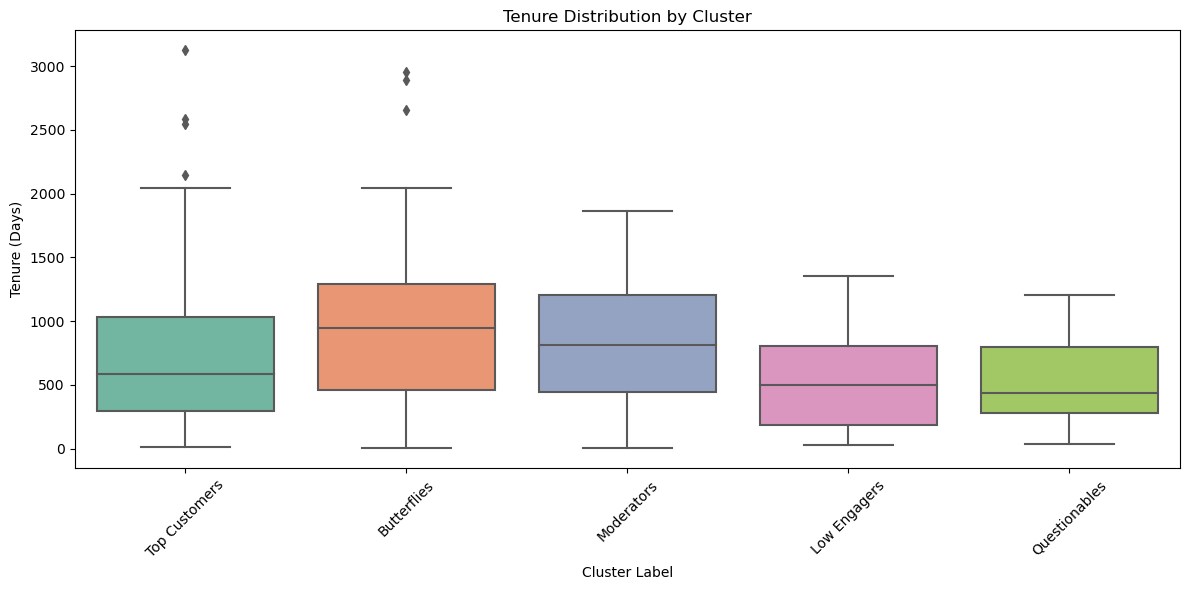

In [54]:
import pandas as pd

# 1) Compute tenure per customer–product pair
# Assume df has columns: Customer ID, Product Group, Start of rental, End of rental
df['Start of rental'] = pd.to_datetime(df['Start of rental'])
df['End of rental']   = pd.to_datetime(df['End of rental'])

tenure_df = (
    df
    .groupby(['Customer ID','Product Group'], as_index=False)
    .agg(
        First_Start=('Start of rental','min'),
        Last_End   =('End of rental','max')
    )
)
tenure_df['Tenure_Days'] = (tenure_df['Last_End'] - tenure_df['First_Start']).dt.days

# 2) Merge in cluster labels from rfm_reg
# Assume rfm_reg has columns: Customer ID, Product Group, Cluster_Label
tenure_df = tenure_df.merge(
    rfm_reg[['Customer ID','Product Group','Cluster_Label']],
    on=['Customer ID','Product Group'],
    how='left'
)

# 3) For each cluster, find the pair with highest and lowest tenure
results = []
for cluster, group in tenure_df.groupby('Cluster_Label'):
    # drop NaN tenures
    sub = group.dropna(subset=['Tenure_Days'])
    if sub.empty:
        continue
    max_row = sub.loc[sub['Tenure_Days'].idxmax()]
    min_row = sub.loc[sub['Tenure_Days'].idxmin()]
    results.append({
        'Cluster': cluster,
        'Highest_Tenure_Pair': (max_row['Customer ID'], max_row['Product Group']),
        'Highest_Tenure_Days': max_row['Tenure_Days'],
        'Lowest_Tenure_Pair': (min_row['Customer ID'], min_row['Product Group']),
        'Lowest_Tenure_Days': min_row['Tenure_Days']
    })

tenure_summary = pd.DataFrame(results)
print(tenure_summary)

# 4) Visualize tenure distribution per cluster
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=tenure_df,
    x='Cluster_Label',
    y='Tenure_Days',
    palette='Set2'
)
plt.xticks(rotation=45)
plt.title('Tenure Distribution by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Tenure (Days)')
plt.tight_layout()


Analysis of the Tenure of the Clusters

ANALYSIS QUESTION:   
How does customer–product tenure (the length of relationship) vary across behavioral clusters, and what can it tell us about customer loyalty, retention potential, and usage patterns?

DATA FINDING:  
Tenure was measured as the number of days between a customer’s first and last rental for each product group.Top Customers showed high median tenure and wide variability, reflecting long-term engagement with occasional high outliers. Butterflies had even higher median tenure but greater variance, indicating sporadic yet high-value relationships.
Moderators maintained steady mid-range tenure with lower variability—stable but less intense. Low Engagers had the shortest, most compact tenures, while Questionables showed consistent engagement over time but at low monetary levels.

INSIGHT:  
Tenure analysis reveals that Top Customers and Butterflies are long-term partners, but only the former are predictable. Butterflies, though valuable, show fragmented behavior and may require more structured re-engagement strategies.
Moderators represent a dependable mid-tier group, while Low Engagers are largely transactional.
Interestingly, Questionables demonstrate loyalty in time but not in value, making them suitable for low-cost retention or bundling strategies targeting consistent but small-scale users.

Persona Definition

In [ ]:
# Merge contract duration and interpurchase time into rfm_reg for summary
rfm_reg_summary = rfm_reg.merge(
    time_regularity_custprod[["Customer ID", "Product Group", "Mean_Interpurchase_Time_custprod"]],
    on=["Customer ID", "Product Group"],
    how="left"
).merge(
    df[["Customer ID", "Product Group", "Contract Duration (days)"]],
    on=["Customer ID", "Product Group"],
    how="left"
)

# Create summary table based on Cluster_Label, now including Recency, Contract Duration, Interpurchase Time, and count
persona_kpi_summary = rfm_reg_summary.groupby('Cluster_Label').agg({
    'Monetary': 'mean',
    'Frequency': 'mean',
    'Recency': 'mean',
    'Contract Duration (days)': 'mean',
    'Mean_Interpurchase_Time_custprod': 'mean',
    'Product Group': lambda x: x.mode()[0] if not x.mode().empty else None,  # Most common product group
}).rename(columns={
    'Monetary': 'Avg Monetary (€)',
    'Frequency': 'Avg Frequency',
    'Recency': 'Avg Recency (Days)',
    'Contract Duration (days)': 'Avg Contract Duration (days)',
    'Mean_Interpurchase_Time_custprod': 'Avg Interpurchase Time (days)',
    'Product Group': 'Top Product Group',
}).reset_index()

# Display the summary table
persona_kpi_summary.head(10)

,Cluster_Label,Avg Monetary (€),Avg Frequency,Avg Recency (Days),Avg Contract Duration (days),Avg Interpurchase Time (days),Top Product Group,Num Customer-Product Pairs
0,Top Customers,887.895741,31.289047,281.813819,148.528994,5.986177,Rotating Boom Lifts,4501
1,Butterflies,919.732698,54.598179,146.244060,130.368867,10.545204,Rotating Boom Lifts,10985
2,Moderators,234.059239,40.852419,241.489590,20.961115,64.453435,Truck Mounted Platforms,3266
3,Low Engagers,127.228667,5.675556,449.288889,3.671111,147.644455,Vertical Lifts,225
4,Questionables,111.490127,4.265823,524.734177,3.924051,202.441983,Vertical Lifts,79


In [56]:
# We'll enrich each Cluster with a marketing or product suggestion based on their KPI pattern
def generate_insight(row):
    if row['Cluster_Label'] == 'Top Customers':
        return "Offer loyalty-based tiered pricing or early renewal incentives for high-value, regular renters."
    elif row['Cluster_Label'] == 'Butterflies':
        return "Implement smart reminders or flexible bundles to convert high-value but irregular customers into regular renters."
    elif row['Cluster_Label'] == 'Moderators':
        return "Nurture with steady-value campaigns and cross-sell into similar product lines for long-term growth."
    elif row['Cluster_Label'] == 'Low Engagers':
        return "Use limited-time offers or entry-level bundles to re-engage one-time or inactive users."
    elif row['Cluster_Label'] == 'Questionables':
        return "Introduce upsell strategies or add-on services for consistent but low-value customers."
    else:
        return "General engagement campaign."

# Apply insights
persona_kpi_summary["Suggested Strategy"] = persona_kpi_summary.apply(generate_insight, axis=1)

# Display the enriched summary table with insights
persona_kpi_summary.head(10)

,Cluster_Label,Customer-Product Pairs,Avg Monetary (€),Avg Frequency,Avg Recency (Days),Top Product Group,Suggested Strategy
0,Top Customers,403,893.686761,12.069479,410.875931,Rotating Boom Lifts,Offer loyalty-based tiered pricing or early re...
1,Butterflies,374,972.213622,30.991979,290.930481,Rotating Boom Lifts,Implement smart reminders or flexible bundles ...
2,Moderators,233,245.586033,14.141631,344.000000,Truck Mounted Platforms,Nurture with steady-value campaigns and cross-...
3,Low Engagers,45,128.389471,5.000000,505.822222,Vertical Lifts,Use limited-time offers or entry-level bundles...
4,Questionables,20,111.021738,3.950000,541.300000,Vertical Lifts,Introduce upsell strategies or add-on services...


Cross Selling Analysis

In [57]:
import pandas as pd
from itertools import combinations


In [58]:
# Keep only rentals from 2021 onwards
df = df[df['Start of rental'].dt.year >= 2021]

# Sort by customer and rental start date
df = df.sort_values(['Customer ID', 'Start of rental'])

pair_list = []

# Loop through each customer
for customer_id, group in df.groupby('Customer ID'):
    group = group.sort_values('Start of rental')
    starts = group['Start of rental'].values
    products = group['Product Group'].values
    n = len(group)

    for i in range(n):
        window_start = starts[i]
        window_end = window_start + np.timedelta64(90, 'D')

        # Select unique products in 90-day window ahead
        mask = (starts > window_start) & (starts <= window_end)
        co_rented = set(products[mask])  # use a set to deduplicate

        for prod2 in co_rented:
            if prod2 != products[i]:
                pair = tuple(sorted([products[i], prod2]))
                pair_list.append((customer_id, pair))  # track who generated it

# Deduplicate same customer-product-pair combinations
unique_pairs = pd.DataFrame(pair_list, columns=['Customer_ID', 'Product_Pair']).drop_duplicates()

# Count frequency of each product pair
pair_counts = unique_pairs['Product_Pair'].value_counts().reset_index()
pair_counts.columns = ['Product Pair', 'Count']

# Show result
print("\nTop Unique Product Pairs Co-Rented Within 90 Days:\n")
print(pair_counts)



Top Unique Product Pairs Co-Rented Within 90 Days:

                                      Product Pair  Count
0            (Rotating Boom Lifts, Vertical Lifts)    237
1              (Rotating Boom Lifts, Telehandlers)    199
2   (Rotating Boom Lifts, Truck Mounted Platforms)    176
3                   (Telehandlers, Vertical Lifts)    161
4        (Truck Mounted Platforms, Vertical Lifts)    139
..                                             ...    ...
93         (Rent Outfitted, Telehandler Accessory)      1
94           (Rent with Crane, Subrental Vehicles)      1
95              (Column Lifts, Subrental Vehicles)      1
96            (Rent with Crane, Various Equipment)      1
97                  (Rent Outfitted, Rent Special)      1

[98 rows x 2 columns]


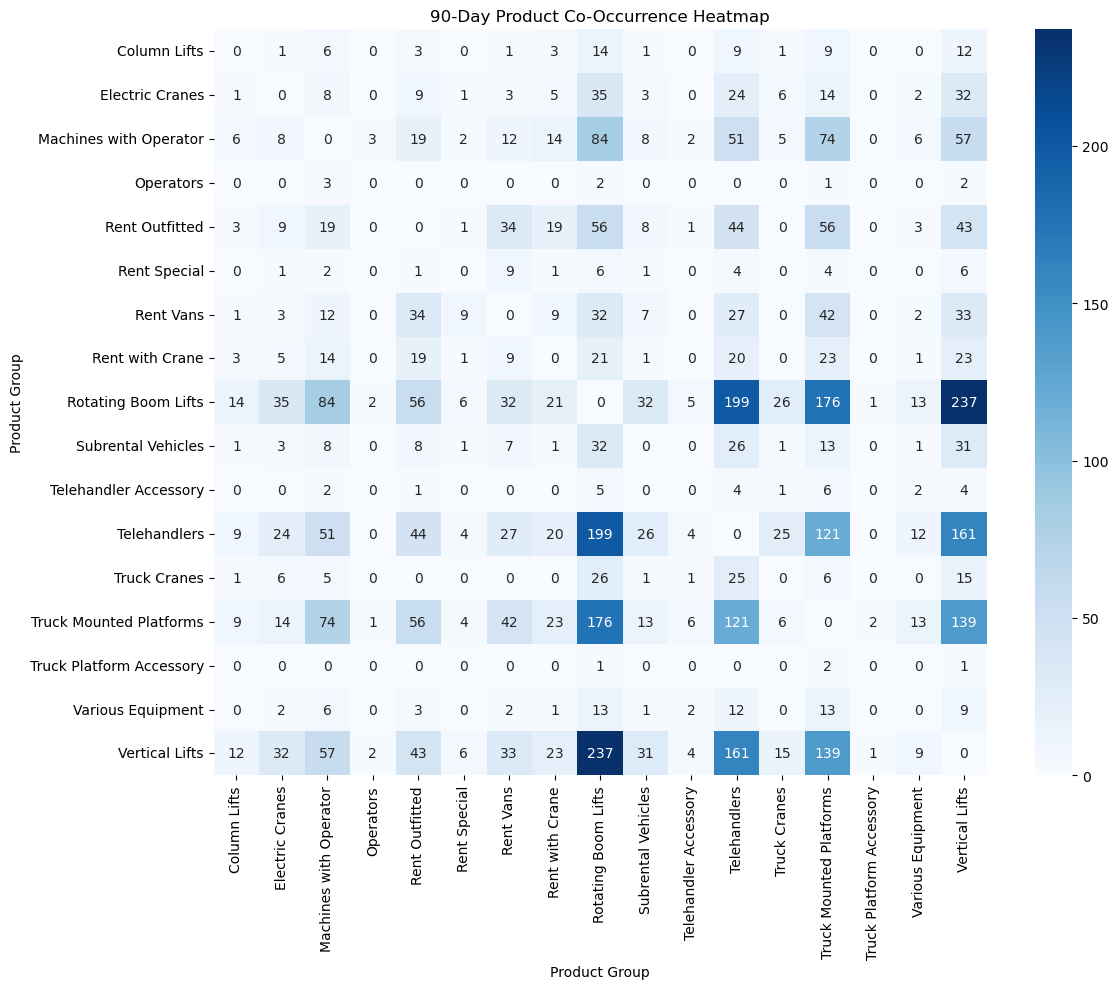

In [59]:
# Expand product pairs into rows and columns
product_set = set()
for pair in pair_counts['Product Pair']:
    product_set.update(pair)

product_list = sorted(product_set)
product_index = {p: i for i, p in enumerate(product_list)}

# Create empty co-occurrence matrix
matrix = np.zeros((len(product_list), len(product_list)), dtype=int)

# Fill matrix with counts
for (prod_a, prod_b), count in pair_counts.values:
    i, j = product_index[prod_a], product_index[prod_b]
    matrix[i, j] = count
    matrix[j, i] = count  # symmetric matrix

# Convert to DataFrame for seaborn heatmap
heatmap_df = pd.DataFrame(matrix, index=product_list, columns=product_list)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='Blues')
plt.title("90-Day Product Co-Occurrence Heatmap")
plt.xlabel("Product Group")
plt.ylabel("Product Group")
plt.tight_layout()
plt.show()

In [60]:
# Filter rentals from 2021 onwards
df = df[df['Start of rental'].dt.year >= 2021]

# Sort by Customer and rental date
df = df.sort_values(['Customer ID', 'Start of rental'])

pair_list = []

# For each customer, find product pairs rented within a 90-day window
for customer_id, group in df.groupby('Customer ID'):
    group = group.sort_values('Start of rental')
    starts = group['Start of rental'].values
    products = group['Product Group'].values
    n = len(group)
    
    for i in range(n):
        window_start = starts[i]
        window_end = window_start + np.timedelta64(90, 'D')
        mask = (starts > window_start) & (starts <= window_end)
        co_rented = set(products[mask])
        
        for prod2 in co_rented:
            if prod2 != products[i]:
                pair = tuple(sorted([products[i], prod2]))
                pair_list.append((customer_id, pair))

# Step 1: Create DataFrame
pair_df = pd.DataFrame(pair_list, columns=['Customer_ID', 'Product_Pair'])
pair_df[['Product_A', 'Product_B']] = pd.DataFrame(pair_df['Product_Pair'].tolist(), index=pair_df.index)

# Step 2: Support for single products
all_rentals = pd.concat([
    pair_df[['Customer_ID', 'Product_A']].rename(columns={'Product_A': 'Product'}),
    pair_df[['Customer_ID', 'Product_B']].rename(columns={'Product_B': 'Product'})
])
support_single = all_rentals.drop_duplicates().groupby('Product')['Customer_ID'].nunique()
total_customers = all_rentals['Customer_ID'].nunique()
support_single = support_single / total_customers

# Step 3: Support for product pairs
support_pair = pair_df.drop_duplicates(subset=['Customer_ID', 'Product_Pair']) \
                      .groupby('Product_Pair')['Customer_ID'].nunique()
support_pair = support_pair / total_customers

# Step 4: Compute Confidence and Lift
results = []

for (prod_a, prod_b), supp_ab in support_pair.items():
    supp_a = support_single.get(prod_a, 0)
    supp_b = support_single.get(prod_b, 0)
    
    if supp_a > 0 and supp_b > 0:
        conf_ab = supp_ab / supp_a
        conf_ba = supp_ab / supp_b
        lift_ab = conf_ab / supp_b
        lift_ba = conf_ba / supp_a

        results.append({
            'Product A': prod_a,
            'Product B': prod_b,
            'Support A': round(supp_a, 4),
            'Support B': round(supp_b, 4),
            'Support (A ∩ B)': round(supp_ab, 4),
            'Confidence (A → B)': round(conf_ab, 4),
            'Confidence (B → A)': round(conf_ba, 4),
            'Lift (A → B)': round(lift_ab, 4),
            'Lift (B → A)': round(lift_ba, 4)
        })

# Step 5: Output DataFrame
mba_df = pd.DataFrame(results).sort_values(by='Lift (A → B)', ascending=False)

# Save or inspect
mba_df.to_csv("mba_rules_90day.csv", index=False)
mba_df.head(10)

,Product A,Product B,Support A,Support B,Support (A ∩ B),Confidence (A → B),Confidence (B → A),Lift (A → B),Lift (B → A)
85,Telehandler Accessory,Various Equipment,0.0110,0.0423,0.0037,0.3333,0.0870,7.8841,7.8841
49,Rent Special,Rent Vans,0.0239,0.1452,0.0165,0.6923,0.1139,4.7673,4.7673
23,Machines with Operator,Operators,0.2408,0.0055,0.0055,0.0229,1.0000,4.1527,4.1527
83,Telehandler Accessory,Truck Cranes,0.0110,0.0662,0.0018,0.1667,0.0278,2.5185,2.5185
41,Rent Outfitted,Rent with Crane,0.2096,0.0735,0.0349,0.1667,0.4750,2.2667,2.2667
4,Column Lifts,Rent with Crane,0.0331,0.0735,0.0055,0.1667,0.0750,2.2667,2.2667
19,Electric Cranes,Truck Cranes,0.0790,0.0662,0.0110,0.1395,0.1667,2.1085,2.1085
40,Rent Outfitted,Rent Vans,0.2096,0.1452,0.0625,0.2982,0.4304,2.0537,2.0537
93,Truck Mounted Platforms,Truck Platform Accessory,0.5257,0.0037,0.0037,0.0070,1.0000,1.9021,1.9021
84,Telehandler Accessory,Truck Mounted Platforms,0.0110,0.5257,0.0110,1.0000,0.0210,1.9021,1.9021


In traditional Market Basket Analysis (MBA), metrics like support, confidence, and lift are used to find product combinations that frequently occur together in customer transactions. We adapted these metrics to the B2B rental context, where products are not bought in the same basket but rented within a time window—specifically, 90 days. so in this context we define Metrics as below:  

Metric Definition:  
- Support(A):  % of customers who rented product A
- Support(A ∩ B):	% of customers who rented both A and B within a 90-day period
- Confidence(A → B);	P(B	A): Probability that a customer buys B given they bought A
- Lift(A → B): How much more likely A and B occur together than if they were independent; Strength of co-rental of A and B compared to the overall rental rate of B

THRESHHOLD DEFINITION

To identify meaningful product pairs for cross-selling, we evaluated the generated association rules based on three key metrics:

Metric	Definition	Recommended Threshold:  
- Support (A ∩ B)	> 0.005 (0.5%)
- Confidence (A → B) > 0.3
- Lift (A → B)-How much more likely B is to be bought with A compared to random chance	> 2.0

Only rules that meet all these thresholds are considered strong and actionable for cross-sell strategies.

RESULT:  
considering the Threshhold, We accepted these tules as effective and useful for cross-selling:
- (A): Telehandler Accessory, (B): Various Equipment; Confidence (A→B):	0.333, Lift (A→B): 7.88	Very strong lift and solid confidence — ideal pair
- (A): Rent Special, (B): Rent Vans;	Confidence (A→B): 0.692, Lift (A→B): 4.77	High conversion likelihood — bundle candidate
- (A): Telehandler Accessory, (B): Truck Mounted Platforms; Confidence (A→B): 1.000, Lift (A→B):1.90	Perfect confidence but marginal lift — context-specific

These three product combinations show strong cross-sell potential. Especially the first two pairs can be leveraged in marketing campaigns or rental bundle designs.

Product Sequence Analysis

In [61]:
# Step 1: Sort rentals by customer and rental date
df = df.sort_values(by=['Customer ID', 'Start of rental'])

# Step 2: Create ordered product sequence for each customer
sequence_df = df.groupby('Customer ID')['Product Group'].apply(list).reset_index()
sequence_df.columns = ['Customer ID', 'Rental Sequence']

# show product sequences for the first few customers
print(sequence_df.head(10))

  Customer ID                                    Rental Sequence
0      cust01                                   [Rent Outfitted]
1      cust02  [Subrental Vehicles, Subrental Vehicles, Subre...
2      cust03  [Rent Vans, Rent Vans, Rent Vans, Rent Vans, R...
3      cust04                              [Rotating Boom Lifts]
4      cust05  [Rotating Boom Lifts, Rotating Boom Lifts, Rot...
5      cust06  [Truck Mounted Platforms, Truck Mounted Platfo...
6      cust07  [Rent Vans, Rent Vans, Rent Special, Rent Vans...
7      cust09  [Rent Outfitted, Telehandlers, Rotating Boom L...
8      cust10  [Rent Vans, Rent Vans, Rent Vans, Rent Vans, R...
9     cust100  [Truck Mounted Platforms, Truck Mounted Platfo...


In [62]:

from collections import Counter
from itertools import tee, islice

# Define a function to extract consecutive product transitions (e.g., A → B → C → D → ...)
def extract_transitions(product_sequence):
    # Creates pairs (A→B, B→C, ...) from a list
    a, b = tee(product_sequence)
    next(b, None)
    return list(zip(a, b))

# Apply transition extraction across all customer sequences
all_transitions = []

for seq in sequence_df['Rental Sequence']:
    all_transitions.extend(extract_transitions(seq))

# Count frequency of each unique transition
transition_counts = Counter(all_transitions)
transition_df = pd.DataFrame(transition_counts.items(), columns=['Transition', 'Count'])
transition_df[['From Product', 'To Product']] = pd.DataFrame(transition_df['Transition'].tolist(), index=transition_df.index)
transition_df = transition_df[['From Product', 'To Product', 'Count']].sort_values(by='Count', ascending=False)

# Save or inspect the transition DataFrame
print(transition_df.head(10))


               From Product               To Product  Count
12      Rotating Boom Lifts      Rotating Boom Lifts   6826
8            Vertical Lifts           Vertical Lifts   5444
29             Telehandlers             Telehandlers   3446
10  Truck Mounted Platforms  Truck Mounted Platforms   2727
44   Machines with Operator   Machines with Operator   1363
47             Column Lifts             Column Lifts   1181
15      Rotating Boom Lifts           Vertical Lifts    889
16           Vertical Lifts      Rotating Boom Lifts    875
2       Rotating Boom Lifts             Telehandlers    861
3              Telehandlers      Rotating Boom Lifts    829


In [63]:
# Calculate total transitions from each product to compute confidence
from_totals = transition_df.groupby('From Product')['Count'].sum().to_dict()

# Add confidence = count(A→B) / total transitions from A
transition_df['Confidence (A → B)'] = transition_df.apply(
    lambda row: round(row['Count'] / from_totals.get(row['From Product'], 1), 4), axis=1
)
# Save or inspect the transition DataFrame with confidence
transition_df = transition_df.sort_values(by='Confidence (A → B)', ascending=False)
print(transition_df.head(10))

# Filter transitions with confidence greater than 0.7
high_confidence_df = transition_df[transition_df['Confidence (A → B)'] > 0.7].reset_index(drop=True)
high_confidence_df.head(10)


                 From Product               To Product  Count  \
169  Truck Platform Accessory  Truck Mounted Platforms      1   
47               Column Lifts             Column Lifts   1181   
11                  Rent Vans                Rent Vans    738   
85      Telehandler Accessory    Telehandler Accessory    140   
0          Subrental Vehicles       Subrental Vehicles    257   
12        Rotating Boom Lifts      Rotating Boom Lifts   6826   
18             Rent Outfitted           Rent Outfitted    790   
44     Machines with Operator   Machines with Operator   1363   
8              Vertical Lifts           Vertical Lifts   5444   
29               Telehandlers             Telehandlers   3446   

     Confidence (A → B)  
169              1.0000  
47               0.9307  
11               0.7785  
85               0.7487  
0                0.7199  
12               0.7172  
18               0.7169  
44               0.7125  
8                0.7123  
29               0.6392 

,From Product,To Product,Count,Confidence (A → B)
0,Truck Platform Accessory,Truck Mounted Platforms,1,1.0000
1,Column Lifts,Column Lifts,1181,0.9307
2,Rent Vans,Rent Vans,738,0.7785
3,Telehandler Accessory,Telehandler Accessory,140,0.7487
4,Subrental Vehicles,Subrental Vehicles,257,0.7199
5,Rotating Boom Lifts,Rotating Boom Lifts,6826,0.7172
6,Rent Outfitted,Rent Outfitted,790,0.7169
7,Machines with Operator,Machines with Operator,1363,0.7125
8,Vertical Lifts,Vertical Lifts,5444,0.7123
